## Beating the Random Walk? Predicting the stock returns using machine learning and common sense

## Foreword and motivation


As humans, we were always curious about what awaits us in the future - perhaps, we still want to have some control over the dynamic environment we live in. Recently, I got a call from my friend, who decided to invest her money into the stock market which is not a bad idea at all, once you see the most recent info on the inflation and interest rates. She sounded rather upset; apparently, she did not become a professional trader after a couple of udemy courses and was losing her hard earned cash. She knew that I was involved in some econometrics projects back in the day and she asked me if I could make her a model that will predict stock market prices on-demand, using some publicly available data. I immediately replied that it is probably simply not possible - stock market data is very noisy, does not have a clear trend most of the time and there wouldn't be any sensible model to do the job consistently. On second thought, this was a cool idea for a small project - 'an exercise for me and an entertainment for you'. However, realistically, just ask yourself - 'if there is a model that can consistently predict stock prices, would I be seeing it on github?'.

... and that is how this project started.

## Brief summary

In this project, I look at some state - of - the - art machine learning algorithms as well as some statistical algorithms in order to predict stock returns of the biggest fin-tech bank of Kazakhstan. Unlike other examples of stock price prediction which just publish low prediction errors, I utilize a couple of fair benchmarks to test the credibility of the model, such as 'times lost to naive forecast' and 'times guessed the sign correctly'. I then design a custom metric to measure and compare the performances of ML algorithms. The data is pooled from YFinance.

## Getting the data

Let's first start with simple stuff - stock prices as univariate time series. Later, we are going to expand and compare the methodologies to make a multivariate forecast.

In [103]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import matplotlib.dates as mdates
import gc
#from ta import add_all_ta_target
from sklearn.preprocessing import StandardScaler
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
from ta.trend import SMAIndicator
import shap
shap.initjs()

We will be using the data for stocks of 'Kaspi Bank' - one of the largest second-tier banks of Kazakhstan, and, coincidentally, my past workplace - I have worked there as a data miner at the risk collection department.

This stock is considered to be a 'blue chip' stock, which may or may not be relevant in the predicting its return.

To pull the data, we will be using Yahoo Finance API which is pretty convenient when it comes to stock prices.

In [2]:
#download the data from yahoo finance
df = yf.download("KSPI.IL")
df = df[df.index <= '2022-12-16']
df


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-15,38.000000,44.959999,33.750000,41.500000,38.185604,4952506
2020-10-16,42.200001,43.485001,41.110001,42.250000,38.875713,428297
2020-10-19,42.994999,42.994999,40.275002,41.500000,38.185604,92311
2020-10-20,40.105000,42.000000,40.105000,41.799999,38.461655,276481
2020-10-21,42.450001,42.549999,41.099998,41.750000,38.415646,129435
...,...,...,...,...,...,...
2022-12-12,73.000000,74.599998,70.400002,72.199997,72.199997,35553
2022-12-13,70.500000,75.099998,70.500000,74.500000,74.500000,32754
2022-12-14,72.199997,75.900002,72.199997,73.500000,73.500000,29184


## Exploratory analysis

Our interest lies in predicting the daily closing prices.\
Let's select the closing prices column and plot the data to see what we are working with:

In [3]:
#summary of the closing prices column
closing_prices_kaspi = df['Close'].copy()
closing_prices_kaspi.describe()

count    549.000000
mean      76.980965
std       26.803257
min       35.000000
25%       53.799999
50%       70.699997
75%       95.199997
max      145.000000
Name: Close, dtype: float64

In [4]:
#check if there are missing values
closing_prices_kaspi = closing_prices_kaspi.to_frame()
closing_prices_kaspi = closing_prices_kaspi.rename(columns = {'Close' : 'Closing_Price'})
closing_prices_kaspi.isna().sum()

Closing_Price    0
dtype: int64

Previous cell shows no missing values. However, let's take the closer look at our dataset again:

In [5]:
closing_prices_kaspi.head(5)

,Closing_Price
Date,
2020-10-15,41.500000
2020-10-16,42.250000
2020-10-19,41.500000
2020-10-20,41.799999
2020-10-21,41.750000


Here we can notice that the date goes from 2020-10-16 to 2020-10-19 => this is because the exchanges are closed on weekends and some holidays. Hence, it is safe to conclude that the prices won't change during the weekends. Let's impute the missing days and plot the data:

In [6]:
closing_prices_kaspi = closing_prices_kaspi.resample('D').ffill().reset_index().set_index('Date')
closing_prices_kaspi

,Closing_Price
Date,
2020-10-15,41.500000
2020-10-16,42.250000
2020-10-17,42.250000
2020-10-18,42.250000
2020-10-19,41.500000
...,...
2022-12-12,72.199997
2022-12-13,74.500000
2022-12-14,73.500000


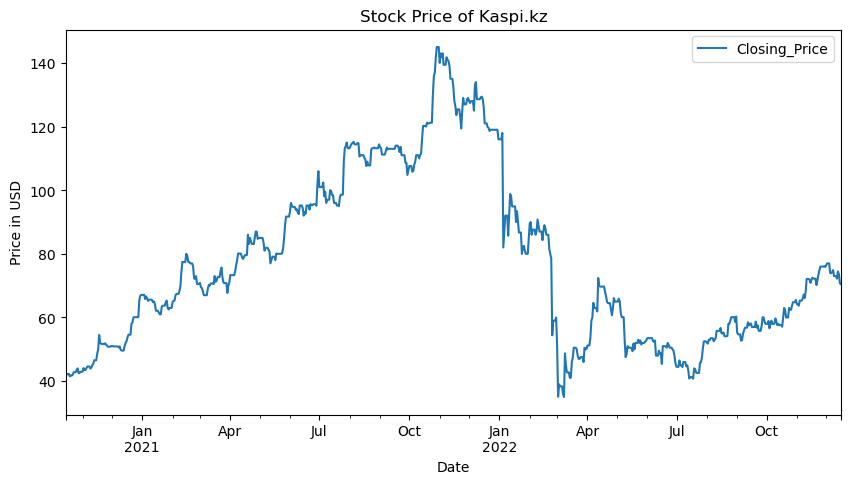

In [7]:
closing_prices_kaspi.plot(figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.title('Stock Price of Kaspi.kz')
plt.show()

We can notice that there was a dramatic drop in the stock price - let's find max and min dates:

In [8]:
close_min = closing_prices_kaspi.query("Closing_Price == Closing_Price.min()").reset_index().Date[0]
close_max = closing_prices_kaspi.query("Closing_Price == Closing_Price.max()").reset_index().Date[0]

Let's add the vertical lines with min and max close price dates:

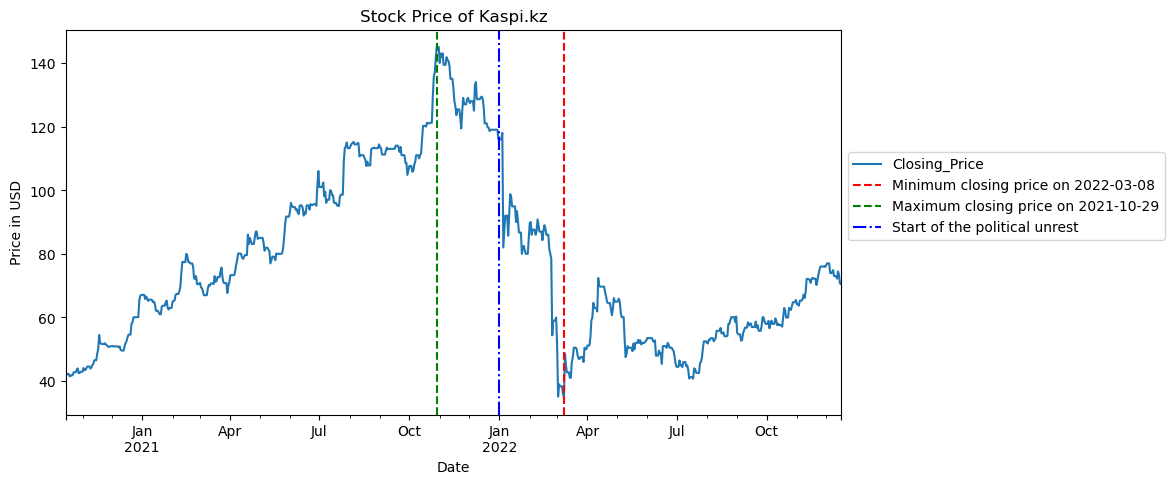

In [9]:
closing_prices_kaspi.plot(figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.title('Stock Price of Kaspi.kz')
plt.xlim(closing_prices_kaspi.reset_index().Date.min(), closing_prices_kaspi.reset_index().Date.max())
plt.axvline(close_min, color = 'red', linestyle = 'dashed', label = f'Minimum closing price on {close_min.date()}')
plt.axvline(close_max, color = 'green', linestyle = 'dashed', label = f'Maximum closing price on {close_max.date()}')
plt.axvline('2022-01', color = 'blue', linestyle = 'dashdot', label = f'Start of the political unrest')
plt.legend(bbox_to_anchor = (1, 0.7), loc = 'upper left')
plt.show()

I have added another vertical line that indicates the start of political unrest in January 2022, after which most (if not all) Kazakhstani stocks drastically fell in price.

However, from the graph, there already was a downward momentum before the unrest.

Let's observe the % change in price between these periods.

In [10]:
points_of_interest = closing_prices_kaspi.reset_index().query\
                            ("Closing_Price == Closing_Price.min() \
                            or Closing_Price == Closing_Price.max()\
                            or Closing_Price == Closing_Price.head(1)\
                            or Closing_Price == Closing_Price.tail(1)\
                            or Date == '2022-01-04'").set_index('Date').drop_duplicates(subset = 'Closing_Price')
                            #since the highest price was on friday, it is now duplicated to saturday and sunday, so we drop them
points_of_interest['%_change_between'] = round(points_of_interest.pct_change() * 100, 1)
points_of_interest['cumulative_%_change'] = round(points_of_interest.Closing_Price.diff().cumsum()/points_of_interest.Closing_Price.iloc[0] *100, 1)

points_of_interest

,Closing_Price,%_change_between,cumulative_%_change
Date,,,
2020-10-15,41.5,NaN,NaN
2021-10-29,145.0,249.4,249.4
2022-01-04,118.0,-18.6,184.3
2022-03-08,35.0,-70.3,-15.7
2022-12-16,70.5,101.4,69.9


From this table, we can see that the stock prices of the company experienced some dramatic swings:

Just in one year from being listed, the stock price rocketed by almost 250%; \
Before the unrest, the stock prices decreased by almost 20%;\
The stock prices reached the minimum on 2022-03-08, losing more than 70% of their values after the political unrest;\
Finally, the stock prices rose again, reaching approximately half of their peak values today. 

Cumulative % change column indicates value of stock relative to the first day of trading.

Before we proceed with our analysis, we should make some transformations to our data. In reality, most people do not care about the stock prices; what they care about are the **stock returns**. Let's derive the daily returns from our data.
\
\
**Return of Investment (ROI for short) can be derived using the following formula:**

$ROI = \frac{(Final\ value\ of\ investment\ -\ Initial\ value\ of\ investment)}{Total\ cost\ of\ investment} $ 
\
\
We then need to make a couple of assumptions for simplicity:
1) We are calculating 'per one stock return', i.e. we buy or sell only one (unit of) stock;
2) No dividients - assume that Kaspi doesn't pay dividients (so now it is justifiable to use close price instead of the adjusted close price)
3) No trading costs (commissions, hidden fees) for now - **this is a strong assumption**, as it is easy to find a trading strategy before costs that beats the 'buy and hold strategy', but it is hard to find a trading strategy that beats 'buy and hold' **after the trading costs.**

With these assumptions, our ROI is equivalent to % change we have calculated earlier.

It is also a common practice to add log prices in stock market predictions.
Below is a code that also adds log of closing prices and the first difference of log of closing prices - notice that the first difference of log closing prices is very similar to our ROI derivations (in fact, if the percentage change is very small, these columns have almost identical numbers).

For further analysis and derivations, I will use the differenced log returns instead of ROI, since they are almost identical.


In [11]:
closing_prices_kaspi_roi = closing_prices_kaspi.copy()
closing_prices_kaspi_roi['Closing_Price_%_change'] = closing_prices_kaspi_roi['Closing_Price'].pct_change()
closing_prices_kaspi_roi['Closing_Price_log'] = np.log(closing_prices_kaspi_roi['Closing_Price'])
closing_prices_kaspi_roi['Closing_Price_log_diff'] = closing_prices_kaspi_roi['Closing_Price_log'].diff()
closing_prices_kaspi_roi

,Closing_Price,Closing_Price_%_change,Closing_Price_log,Closing_Price_log_diff
Date,,,,
2020-10-15,41.500000,NaN,3.725693,NaN
2020-10-16,42.250000,0.018072,3.743604,0.017911
2020-10-17,42.250000,0.000000,3.743604,0.000000
2020-10-18,42.250000,0.000000,3.743604,0.000000
2020-10-19,41.500000,-0.017751,3.725693,-0.017911
...,...,...,...,...
2022-12-12,72.199997,-0.010959,4.279440,-0.011019
2022-12-13,74.500000,0.031856,4.310799,0.031359
2022-12-14,73.500000,-0.013423,4.297285,-0.013514


Let's plot the first difference of the log returns:

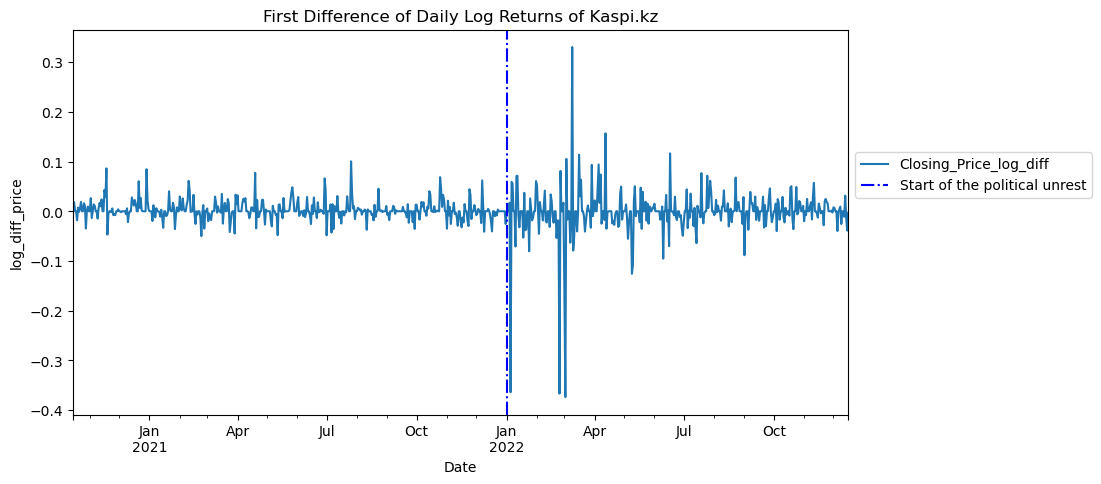

In [12]:
closing_prices_kaspi_roi[['Closing_Price_log_diff']].plot(figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("log_diff_price")
plt.title('First Difference of Daily Log Returns of Kaspi.kz')
plt.xlim(closing_prices_kaspi.reset_index().Date.min(), closing_prices_kaspi.reset_index().Date.max())
plt.axvline('2022-01', color = 'blue', linestyle = 'dashdot', label = f'Start of the political unrest')
plt.legend(bbox_to_anchor = (1, 0.7), loc = 'upper left')
plt.show()

We now have a completely different graph! 

Notice how this graph seems to be more stationary than our starting graph. Since most (if not all) ML algorithms do not extrapolate well (which means that they do not perform well on unseen values, i.e. if you train a model on data between zero and one and you later ask your model to predict value for thousand, your model is likely to throw out some crazy prediction, because it did not see this number before), using log differencing helps us to de-trend the initial time series and, hopefully, make better predictions since most of the models would prefer having stationary time series.

Let's check the stationarity of our initial and transformed time series. For this, we will be using Augmented Dickey–Fuller test.

In [13]:
from statsmodels.tsa.stattools import adfuller

#define an interpretable function
#accepts only one column as input

def adfuller_test(df, alpha):
    
    p_value = round(adfuller(df)[1], 5)
    print('Null hypothesis: Time series is NOT stationary')
    print('Alternative hypothesis: Time series is stationary\n')
    
    if p_value < alpha:
        print(f'The p-value is {p_value}. Since p-value is less than alpha, this time series is stationary => Reject the null')
    else:
        print(f'The p-value is {p_value}. Since p-value is more than alpha, this time series is not stationary => Failed to reject the null')

In [14]:
adfuller_test(closing_prices_kaspi_roi['Closing_Price'], 0.05)

Null hypothesis: Time series is NOT stationary
Alternative hypothesis: Time series is stationary

The p-value is 0.39502. Since p-value is more than alpha, this time series is not stationary => Failed to reject the null


In [15]:
adfuller_test(closing_prices_kaspi_roi['Closing_Price_log_diff'].dropna(), 0.01) #since we do the differencing, our first ROI value is Nan

Null hypothesis: Time series is NOT stationary
Alternative hypothesis: Time series is stationary

The p-value is 0.0. Since p-value is less than alpha, this time series is stationary => Reject the null


As expected, the differenced log returns are stationary even at 1% significance level, while the initial time series with original prices is not.\
What now?

## Statistical models

Let's define our goals:

1) Establish a performance baseline -> we need to choose a baseline to compare the performance of our models;
2) Make a forecast -> specifically, forecast the stock price values for the next N days;
3) Extend the univariate time series problem into the multivariate dimension.

We also need to think about testing our model. We can utilize both cross-validation and a holdout set to assess the performance of the model. Let's make a holdout set that contains the last 30 values of the full data:

In [16]:
training_set = closing_prices_kaspi_roi[:-30].copy()
holdout = closing_prices_kaspi_roi[-30:].copy()
print(f'Size of the training set: {training_set.shape}')
print(f'Size of the holdout set: {holdout.shape}')

Size of the training set: (763, 4)
Size of the holdout set: (30, 4)


In [17]:
training_index = closing_prices_kaspi_roi.index <= training_set.index[-1]
holdout_index = ~training_index 
#here we create training and test indices for future computations and predictions

Before making any actual predictions, a good practice is to is to establish a 'naive', baseline prediction. Basically, what is the best thing to do when you don't know the future return? From the graphs before, we can see that the daily price values are usually close to their last value, so a reasonable assumption we can make is that 'tomorrow will be like yesterday':

In [18]:
training_set['Closing_Price_log_diff'][-1] #this is the last value known in the training data

0.015395663956409678

In [19]:
training_set

,Closing_Price,Closing_Price_%_change,Closing_Price_log,Closing_Price_log_diff
Date,,,,
2020-10-15,41.500000,NaN,3.725693,NaN
2020-10-16,42.250000,0.018072,3.743604,0.017911
2020-10-17,42.250000,0.000000,3.743604,0.000000
2020-10-18,42.250000,0.000000,3.743604,0.000000
2020-10-19,41.500000,-0.017751,3.725693,-0.017911
...,...,...,...,...
2022-11-12,72.099998,0.000000,4.278054,0.000000
2022-11-13,72.099998,0.000000,4.278054,0.000000
2022-11-14,71.800003,-0.004161,4.273885,-0.004170


In [20]:
#use the last known value for future dates
closing_prices_kaspi_roi['naive_forecast'] = np.where(holdout_index, round(training_set['Closing_Price_log_diff'][-1], 5), np.nan)
closing_prices_kaspi_roi['actual_values'] =  closing_prices_kaspi_roi['Closing_Price_log_diff'][-30:]

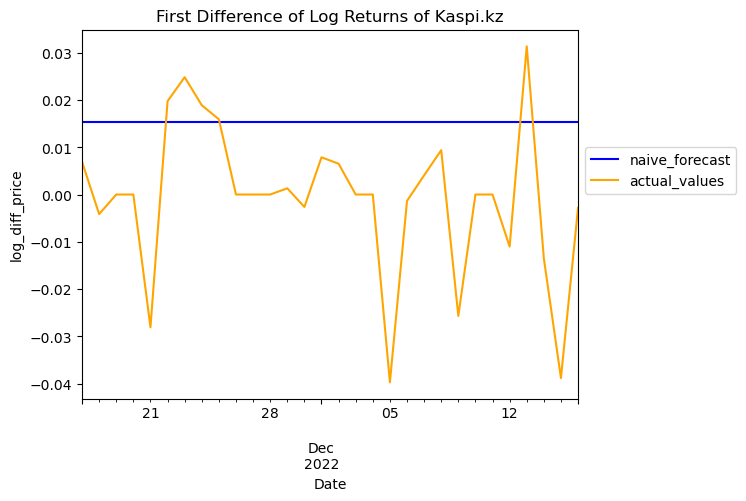

In [21]:
# plot our predictions

closing_prices_kaspi_roi['naive_forecast'].plot(color = 'blue')
closing_prices_kaspi_roi['actual_values'].plot(color = 'orange')
plt.xlabel("Date")
plt.ylabel("log_diff_price")
plt.title('First Difference of Log Returns of Kaspi.kz')
plt.xlim(holdout.reset_index()['Date'].min(), holdout.reset_index()['Date'].max())
plt.legend(bbox_to_anchor = (1, 0.7), loc = 'upper left')
plt.show()

As you can notice, our forecast is not very appealing visually - it is just a horizontal line. Let's see the performance in terms of metrics - since this is a regression problem, we can look at the 'classic' metrics, R^2, RMSE and MAPE: **#add comments about metrics**

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

def evaluate(y_true, y_pred, mape = False, smape = False):
    y_true = y_true.dropna()
    y_pred = y_pred.dropna()
    if len(y_true) != len(y_pred):
        y_true = y_true[len(y_true) - len(y_pred):]
    
    
   
    print(f'RMSE: {np.sqrt(mean_absolute_error(y_true.dropna(),y_pred.dropna()))}')
    print(f'R^2: {r2_score(y_true.dropna(),y_pred.dropna())}')
    
    if mape == True:
        print(f'MAPE: {mean_absolute_percentage_error(y_true.dropna(),y_pred.dropna())}')
    if smape == True:
        def smape(y_true, y_pred):
            numerator = np.abs(y_true - y_pred)
            denominator = (np.abs(y_true) + np.abs(y_pred))
            ratio = numerator / denominator
            return ratio.mean() * 100

        print(f'SMAPE: {smape(y_true.dropna(),y_pred.dropna())}')
    


In [23]:
evaluate(closing_prices_kaspi_roi['actual_values'], closing_prices_kaspi_roi['naive_forecast'], mape = True, smape = False)

RMSE: 0.1354673144047829
R^2: -1.0076253781199016
MAPE: 20806630278453.684


It turns out that MAPE is not a good metric to use in this particular case (differenced values) => since our true values are close to zero, MAPE is exploding.\
Other than that, we have a large RMSE, which is not surprising and a negative R^2 which tells us that our naive forecast is a bad fit.
Now that we have a baseline, let's try to see if we can beat it using some statistical modelling.

Let's try the Holt-Winters model. The key idea behind this method is to model the trend, seasonality and the level of time series. Assuming that they are additively separable (which they don't have to be), the simplified output equation takes the form of:\
\
$Output\ =\ level\ +\ trend\ +\ seasonal$ 


Holt-Winters model utilizes the triple exponential smoothing to smoothen the (trend, level and seasonality components) of the time series and uses the past values to predict future values. 


In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


model = ExponentialSmoothing(
    training_set['Closing_Price_log'], # notice that I use log prices instead of ROI => if we use ROI, our forecast will fail to converge
    initialization_method='heuristic',
    trend='add')

res = model.fit()

e:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [25]:
closing_prices_kaspi_roi.loc[training_index, 'HoltWintersFit'] = res.fittedvalues
closing_prices_kaspi_roi.loc[holdout_index, 'HoltWintersPred'] = res.forecast(30).to_numpy() #forecasting next 30 values; NOT converting it to numpy gives an error 

<AxesSubplot:xlabel='Date'>

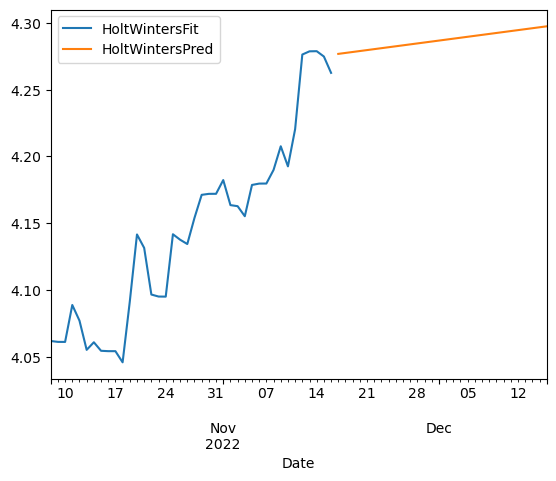

In [26]:
# plot the results
closing_prices_kaspi_roi[['HoltWintersFit', 'HoltWintersPred']][-70:].plot()

To compare our predictions to the naive forecast, we need to take their exponent (to undo the log) and calculate the percentage change:

In [27]:
closing_prices_kaspi_roi['HoltWintersPred%change'] = closing_prices_kaspi_roi['HoltWintersPred'].diff()

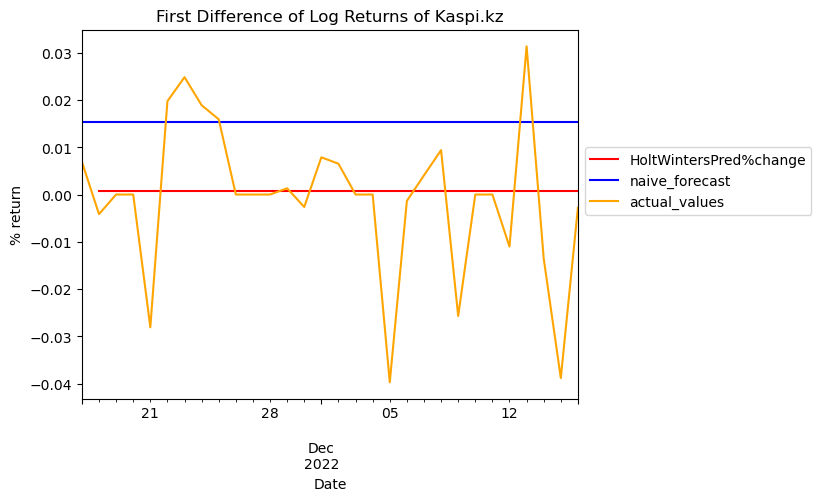

In [29]:
# plot our predictions
closing_prices_kaspi_roi['HoltWintersPred%change'].plot(color = 'red') #the first value is missing since we take % change
closing_prices_kaspi_roi['naive_forecast'].plot(color = 'blue')
closing_prices_kaspi_roi['actual_values'].plot(color = 'orange')
plt.xlabel("Date")
plt.ylabel("% return")
plt.title('First Difference of Log Returns of Kaspi.kz')
plt.xlim(holdout.reset_index()['Date'].min(), holdout.reset_index()['Date'].max())
plt.legend(bbox_to_anchor = (1, 0.7), loc = 'upper left')
plt.show()

Just visually, we can see that the Holt-Winters model did a much better job at fitting the stock returns curve. Notice that the predicted values (returns) of the model are very close to zero.

Let's evaluate our forecast:

In [30]:
evaluate(closing_prices_kaspi_roi['actual_values'], closing_prices_kaspi_roi['HoltWintersPred%change'])

RMSE: 0.10408133947579955
R^2: -0.010636889553602646


Our RMSE lowered by 0.03 and our R^2 is almost 0 now.

Quantitatively, this model beats the naive forecast, but practically, it doesn't have much use.

Up next, we can try using another popular statistical model, ARIMA, which combines the best practices of Auto Regression, Moving Average and Integration into a single model. ARIMA is a large topic on its own, so I will try to make a brief summary here. Basically, there are three parts:
1) AR ($p$) (autoregression of order $p$) which tells us that future values depend on past $p$ values. It usually has the form of\
$\hat{y_t} = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} ... + \beta_py_{t-p} + \epsilon_t$
2) MA ($q$) (moving average of order $q$) has nothing to do with simple or exponential moving average. It tells us that the future values depend on the past errors of time series:\
$\hat{y_t} = \alpha_0 + \alpha_1\epsilon_{t-1} + \alpha_2\epsilon_{t-2} + ... + \alpha_q\epsilon_{t-q} + \epsilon_t$
3) Integration of order $d$ - this part takes the difference between points of time series, i.e.\
$\Delta y_t = y_t - y_{t-1}$\
As we saw earlier, differencing helps to make time series stationary.
Let's try to implement ARIMA on our data.

In [31]:
# import ARIMA, acf and pacf plots, which 'help' to determine the orders of AR and MA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

Let's start from fitting arbitrary numbers - I chose ARIMA(1,0,1)

In [32]:
arima = ARIMA(training_set['Closing_Price_log_diff'], order=(1,0,1)) #fit AR(1), I(0), MA(1) => arbitrarily chosen
arima_result = arima.fit()

e:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [33]:
closing_prices_kaspi_roi.loc[training_index, 'ARIMA101'] = arima_result.predict(start=training_set.index[0], end=training_set.index[-1])
closing_prices_kaspi_roi.loc[holdout_index, 'ARIMA101pred'] = arima_result.get_forecast(30).predicted_mean
#convert our forecast back to pct change
#closing_prices_kaspi_roi['ARIMA101diff'] = np.exp(closing_prices_kaspi_roi['ARIMA111pred']).pct_change() * 100

Plot our ARIMA(1,0,1) prediction:

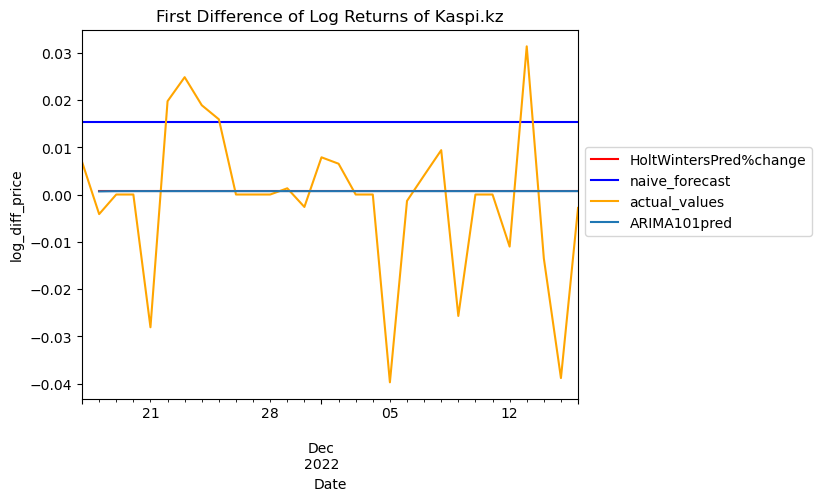

In [34]:
# plot our predictions
closing_prices_kaspi_roi['HoltWintersPred%change'].plot(color = 'red') #the first value is missing since we take % change
closing_prices_kaspi_roi['naive_forecast'].plot(color = 'blue')
closing_prices_kaspi_roi['actual_values'].plot(color = 'orange')
closing_prices_kaspi_roi['ARIMA101pred'][-29:].plot()
plt.xlabel("Date")
plt.ylabel("log_diff_price")
plt.title('First Difference of Log Returns of Kaspi.kz')
plt.xlim(holdout.reset_index()['Date'].min(), holdout.reset_index()['Date'].max())
plt.legend(bbox_to_anchor = (1, 0.7), loc = 'upper left')
plt.show()

Turns out that ARIMA(1,0,1) is also a horizontal line and is almost identical to Holt-Winters model. Note that the prediction error is slightly lower now:

In [35]:
evaluate(closing_prices_kaspi_roi['actual_values'], closing_prices_kaspi_roi['ARIMA101pred'][-30:])

RMSE: 0.10342945035062308
R^2: -0.008739159007934427


Now, let's try to choose appropriate orders for our ARIMA model. One rather popular way to do this is to use ACF (Autocorrelation function) and PACF (Partial autocorrelation function) plots. ACF is used to determine the order of Moving Average, while PACF is used to determine the order of AutoRegression. Let's throw in some plots:

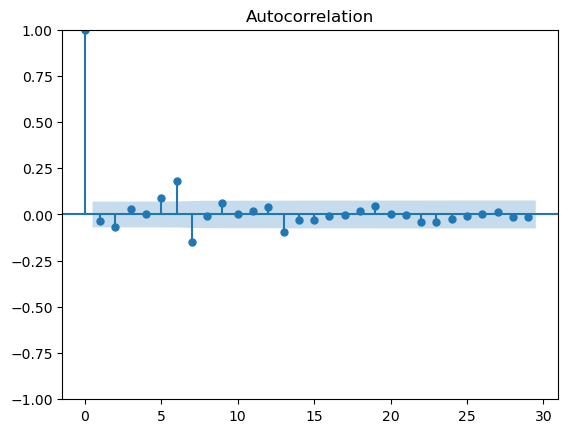

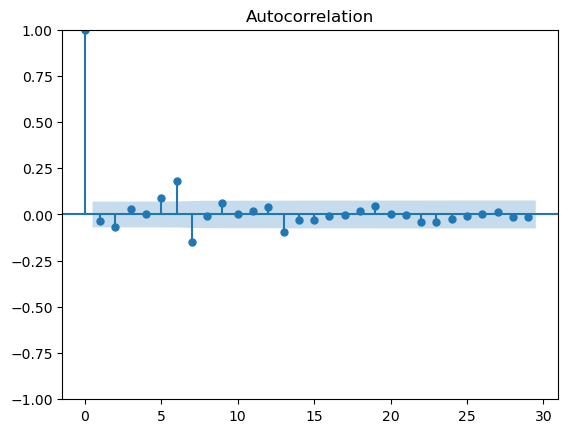

In [36]:
plot_acf(closing_prices_kaspi_roi['Closing_Price_log_diff'].dropna())

How do we interpret this graph? Basically, it shows the correlation of $y_t$ with $y_{t-1}, y_{t-2}, ...$ The correlation at lag 0 is always 1 since the correlation of variable with itself equals one. From the graph above, we can notice that lag 6 and 7 have positive and negative correlation with $y_t$. The blue box represents the confidence interval - points outside the confidence interval reject the null hypothesis that the correlation of $y_t$ with that specific lag is zero.

e:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


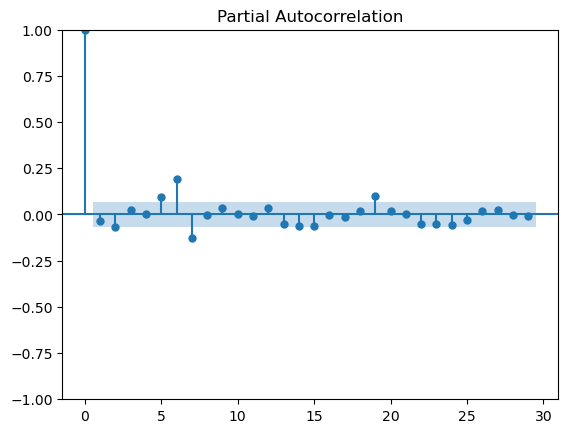

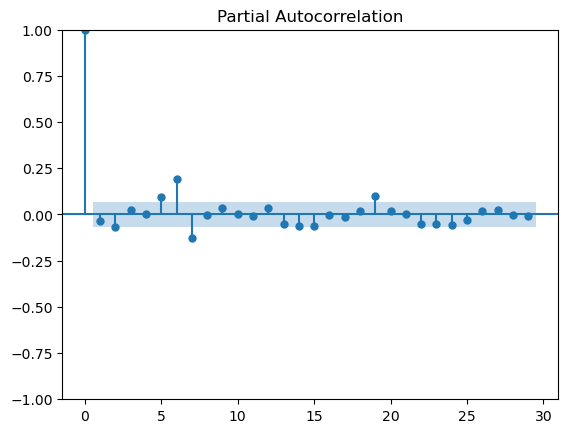

In [37]:
plot_pacf(closing_prices_kaspi_roi['Closing_Price_log_diff'].dropna())

As for PACF, we calculate the conditional correlation, i.e. what is the relationship between y(1) and y(3) given y(2)? Suppose we want to predict y(3) with y(1) => if y(2) is not helpful to predict y(3), the PACF will be large (and outside of the confidence bound) so y(1) should be included in the model. Here we can notice that y(6) and y(7) are outside of the confidence interval.

Basically, people just look at the latest non-zero lag (accompanied by non-random pattern) of ACF and PACF to select the order of MA(q) and AR(p) respectively. Based on the graphs above, we can choose ARIMA of order (7,0,7). Keep in mind that selecting ARIMA order in such manner may or may not yield optimal results, in other words, **ACF and PACF method does not guarantee an optimal model.** On the other hand, we can treat (p,d,q) selection as a hyperparameter optimization problem, or , we can use AutoARIMA (it may still yield suboptimal results though) to choose (p,d,q) for us. I will leave this as an exercise for the reader.

Let's try to fit ARIMA(7,0,7) now:

In [38]:
arima2 = ARIMA(training_set['Closing_Price_log_diff'], order=(7,0,7)) #fit AR(7), I(0), MA(7)
arima_result2 = arima2.fit()

e:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizatio

We can see that it returns a warning about failing to converge. We might now suspect that the values in the plots above were due to the random noise.

In [39]:
closing_prices_kaspi_roi.loc[training_index, 'ARIMA707'] = arima_result.predict(start=training_set.index[0], end=training_set.index[-1])
closing_prices_kaspi_roi.loc[holdout_index, 'ARIMA707pred'] = arima_result.get_forecast(30).predicted_mean
#convert our forecast back to pct change
#closing_prices_kaspi_roi['ARIMA717%change'] = np.exp(closing_prices_kaspi_roi['ARIMA717pred']).pct_change() * 100


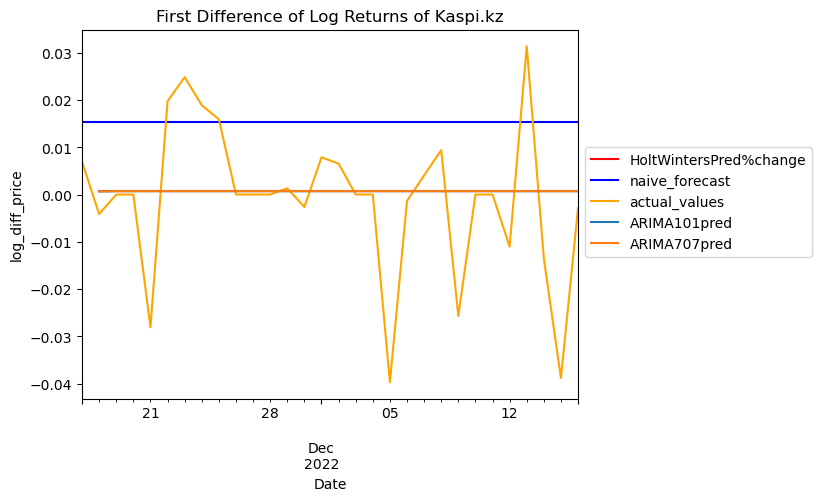

In [40]:
# plot our predictions
closing_prices_kaspi_roi['HoltWintersPred%change'].plot(color = 'red') #the first value is missing since we take % change
closing_prices_kaspi_roi['naive_forecast'].plot(color = 'blue')
closing_prices_kaspi_roi['actual_values'].plot(color = 'orange')
closing_prices_kaspi_roi['ARIMA101pred'][-29:].plot()
closing_prices_kaspi_roi['ARIMA707pred'][-29:].plot()
plt.xlabel("Date")
plt.ylabel("log_diff_price")
plt.title('First Difference of Log Returns of Kaspi.kz')
plt.xlim(holdout.reset_index()['Date'].min(), holdout.reset_index()['Date'].max())
plt.legend(bbox_to_anchor = (1, 0.7), loc = 'upper left')
plt.show()

As we can see, there is no difference between ARIMA(1,0,1) and ARIMA(7,0,7), Let's try AutoARIMA:

In [41]:
import pmdarima as pm
model = pm.auto_arima(training_set['Closing_Price_log_diff'].dropna(),
                      trace=True,
                      suppress_warnings=True,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2880.995, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2869.949, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2868.992, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2869.145, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2868.573, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2868.731, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-2864.974, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2864.881, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2867.513, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2866.750, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2866.808, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-2874.641, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2870.947, Time=0.68 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 3.353 seconds


Let's evaluate its predictions: 

In [42]:
#let's look at the predictions:
closing_prices_kaspi_roi.loc[holdout_index, 'ARIMA202pred'] = model.predict(n_periods=30)


In [43]:
evaluate(closing_prices_kaspi_roi['actual_values'], closing_prices_kaspi_roi['ARIMA202pred'][-30:])

RMSE: 0.10333641404092396
R^2: 0.032720806165248195


It seems that, indeed, we have some marginal improvement over our past R^2 but our RMSE did not improve by much.

## Machine learning for stock returns

As we proceed to try and solve this problem with machine learning, we might want to undo our initial transformation (remember how we filled in the missing days in the data at the very start?). This is because statistical models that we used heavily rely on the time intervals and they do not accept incomplete intervals as their input (trying to input raw working week data without imputing saturdays and sundays might give some unexpected results). In the Machine Learning section, however, we can use a monotonically increasing index (rather than datetime index) for each following observation.
Let's convert the datetime values to a monotone index and store datetime indices separately:

In [44]:
clean =  df[['Close', 'Volume', 'Open', 'High', 'Low']].copy()
clean

,Close,Volume,Open,High,Low
Date,,,,,
2020-10-15,41.500000,4952506,38.000000,44.959999,33.750000
2020-10-16,42.250000,428297,42.200001,43.485001,41.110001
2020-10-19,41.500000,92311,42.994999,42.994999,40.275002
2020-10-20,41.799999,276481,40.105000,42.000000,40.105000
2020-10-21,41.750000,129435,42.450001,42.549999,41.099998
...,...,...,...,...,...
2022-12-12,72.199997,35553,73.000000,74.599998,70.400002
2022-12-13,74.500000,32754,70.500000,75.099998,70.500000
2022-12-14,73.500000,29184,72.199997,75.900002,72.199997


In [45]:
clean['logdiff'] = np.log(clean['Close']).diff()
datetime_id = clean.reset_index()['Date']
clean['h-l'] = clean['High'].copy() - clean['Low'].copy()
clean['c-o'] = clean['Close'].copy() - clean['Open'].copy()
clean.drop(['Close', 'High', 'Low', 'Open'], axis = 1, inplace = True)
clean_num_ind = clean.reset_index().drop('Date', axis = 1).copy()

I also generate additional features like the difference between high and low price and the difference between close and open price.

In [46]:
clean_num_ind

,Volume,logdiff,h-l,c-o
0,4952506,NaN,11.209999,3.500000
1,428297,0.017911,2.375000,0.049999
2,92311,-0.017911,2.719997,-1.494999
3,276481,0.007203,1.895000,1.695000
4,129435,-0.001197,1.450001,-0.700001
...,...,...,...,...
544,35553,-0.011019,4.199997,-0.800003
545,32754,0.031359,4.599998,4.000000
546,29184,-0.013514,3.700005,1.300003
547,27801,-0.038840,5.700005,-2.300003


In [47]:
datetime_id #store the datetime index separately

0     2020-10-15
1     2020-10-16
2     2020-10-19
3     2020-10-20
4     2020-10-21
         ...    
544   2022-12-12
545   2022-12-13
546   2022-12-14
547   2022-12-15
548   2022-12-16
Name: Date, Length: 549, dtype: datetime64[ns]

Since we are trying to predict continuous values over some period of time, this is a classical regression problem. In our case, the dependent variable (the variable we are trying to predict) is the difference in log prices (**a.k.a log returns**).

So, why do we actually care about predicting log returns instead of log prices? Since log transformation 'compresses' the points, this makes points closer to each other, thus making the data more stationary. However, stock prices are very volatile and this transformation is usually not enough, so it is a common practice to take the first difference of log prices as well. By taking the first difference, we remove the volatility within the data as well as the autocorrelation between our dependent variable and its lagged versions. Another advantage of using log returns - given that we have multiple stocks, their prices are usually not comparable one-to-one, while their log returns are.



**What about our predictor variables?**

To answer this question, we need to think about what information can we use to predict the price at time T+1. For stock prices, we usually would have the information about time T, T-1, ... up to T-n, the very first day of trading. So, the answer is straightforward - we need to somehow use the historical data in order to predict the future prices.

This brings us to the concept of lagged variables => we can lag target and predictor variables and use them as our predictors.

If we are using non-transformed prices, our regression will have the form of:

$\hat{y}_{t+1} = \beta_0 + \beta_1y_{t}$

Just as simple as that.

We need to obtain the lagged values of our desired columns.\
Let's try to do that now:




In [48]:
# this function generates lags for list of columns in the provided dataframe

def generate_lags(df, columns, nlags):
    newdata = df.copy()
    for column in columns:
        for lag in range(1,nlags + 1):
            newdata[f'{column}_' + f'lag_{lag}'] = newdata[column].shift(lag)

    return newdata

In [49]:
data_t = clean_num_ind[['logdiff', 'Volume']].copy()
data_t = generate_lags(data_t.dropna(), ['logdiff', 'Volume'], 3)
data_t

,logdiff,Volume,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
1,0.017911,428297,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.017911,92311,0.017911,NaN,NaN,428297.0,NaN,NaN
3,0.007203,276481,-0.017911,0.017911,NaN,92311.0,428297.0,NaN
4,-0.001197,129435,0.007203,-0.017911,0.017911,276481.0,92311.0,428297.0
5,0.005970,10417,-0.001197,0.007203,-0.017911,129435.0,276481.0,92311.0
...,...,...,...,...,...,...,...,...
544,-0.011019,35553,-0.025694,0.009390,0.004051,14092.0,29651.0,48240.0
545,0.031359,32754,-0.011019,-0.025694,0.009390,35553.0,14092.0,29651.0
546,-0.013514,29184,0.031359,-0.011019,-0.025694,32754.0,35553.0,14092.0
547,-0.038840,27801,-0.013514,0.031359,-0.011019,29184.0,32754.0,35553.0


The cost of generating N lags is that the first N points become unusable for our forecast as can be seen above, since the first N points have missing values.
For now, let's assume that we need to predict logdiff by using its past values as well as the Volume variable. (we are going to expand our final dataset later)

In classic ML problems, we always do the train-test split to avoid overfitting. With time-series it is a bit trickier - we don't want to use real label values in the test set and run predict function that way. To illustrate this point, suppose that we need to make a prediction for the next three days, using a three-day-lag. The prediction for the first day will have the following form:

$\hat{y}_{t+1} = \beta_0 + \beta_1y_{t} + \beta_2y_{t-1} + \beta_3y_{t-2} + \epsilon_{t+1}$

Predicting the first day is not that hard, since we know the values for $y_{t}, y_{t-1}, y_{t-2}$ (we do not know the value for epsilon though, so we just set it to zero (under assumption that the error term follows a normal distribution with mean 0 and variance of sigma^2)). \
However, what happens if we need to make prediction for t+2?

$\hat{y}_{t+2} = \beta_0 + \beta_1y_{t+1} + \beta_2y_{t} + \beta_3y_{t-1} + \epsilon_{t+2}$

We don't have value for $y_{t+1}$, so what do we do? The best thing that we can do about it is to plug our forecasted value $\hat{y}_{t+1}$:

$\hat{y}_{t+2} = \beta_0 + \beta_1\hat{y}_{t+1} + \beta_2y_{t} + \beta_3y_{t-1} + \epsilon_{t+2}$

Same procedure is applied to get the final prediction:

$\hat{y}_{t+3} = \beta_0 + \beta_1\hat{y}_{t+2} + \beta_2\hat{y}_{t+1}+ \beta_3y_{t} + \epsilon_{t+3}$

It is important to note that this works only for the dependent variable and its lags. For the independent variables, we will not have t+2 or t+3 observed. It is best to see this visually on this dataset:

In [50]:
data_r = clean_num_ind.copy()
data_r.loc[data_r.index[-1] + 1] = np.nan
data_r

,Volume,logdiff,h-l,c-o
0,4952506.0,NaN,11.209999,3.500000
1,428297.0,0.017911,2.375000,0.049999
2,92311.0,-0.017911,2.719997,-1.494999
3,276481.0,0.007203,1.895000,1.695000
4,129435.0,-0.001197,1.450001,-0.700001
...,...,...,...,...
545,32754.0,0.031359,4.599998,4.000000
546,29184.0,-0.013514,3.700005,1.300003
547,27801.0,-0.038840,5.700005,-2.300003
548,42351.0,-0.002833,3.700005,-0.500000


Assume that we need to make a 3 day ahead prediction using these two columns. We need to predict the very last row - day 549. Let's generate the lagged features:

In [51]:
temp1 = generate_lags(data_r, columns = ['logdiff', 'Volume'], nlags = 3)
temp1

,Volume,logdiff,h-l,c-o,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
0,4952506.0,NaN,11.209999,3.500000,NaN,NaN,NaN,NaN,NaN,NaN
1,428297.0,0.017911,2.375000,0.049999,NaN,NaN,NaN,4952506.0,NaN,NaN
2,92311.0,-0.017911,2.719997,-1.494999,0.017911,NaN,NaN,428297.0,4952506.0,NaN
3,276481.0,0.007203,1.895000,1.695000,-0.017911,0.017911,NaN,92311.0,428297.0,4952506.0
4,129435.0,-0.001197,1.450001,-0.700001,0.007203,-0.017911,0.017911,276481.0,92311.0,428297.0
...,...,...,...,...,...,...,...,...,...,...
545,32754.0,0.031359,4.599998,4.000000,-0.011019,-0.025694,0.009390,35553.0,14092.0,29651.0
546,29184.0,-0.013514,3.700005,1.300003,0.031359,-0.011019,-0.025694,32754.0,35553.0,14092.0
547,27801.0,-0.038840,5.700005,-2.300003,-0.013514,0.031359,-0.011019,29184.0,32754.0,35553.0
548,42351.0,-0.002833,3.700005,-0.500000,-0.038840,-0.013514,0.031359,27801.0,29184.0,32754.0


We are predicting logdiff based on the lagged columns - we do not use the original Volume and logdiff as our variables. Suppose our model predicted a value of logdiff = 0.1 for day 549:

In [52]:
temp1.loc[temp1.index[-1], 'logdiff'] = 0.1
temp1

,Volume,logdiff,h-l,c-o,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
0,4952506.0,NaN,11.209999,3.500000,NaN,NaN,NaN,NaN,NaN,NaN
1,428297.0,0.017911,2.375000,0.049999,NaN,NaN,NaN,4952506.0,NaN,NaN
2,92311.0,-0.017911,2.719997,-1.494999,0.017911,NaN,NaN,428297.0,4952506.0,NaN
3,276481.0,0.007203,1.895000,1.695000,-0.017911,0.017911,NaN,92311.0,428297.0,4952506.0
4,129435.0,-0.001197,1.450001,-0.700001,0.007203,-0.017911,0.017911,276481.0,92311.0,428297.0
...,...,...,...,...,...,...,...,...,...,...
545,32754.0,0.031359,4.599998,4.000000,-0.011019,-0.025694,0.009390,35553.0,14092.0,29651.0
546,29184.0,-0.013514,3.700005,1.300003,0.031359,-0.011019,-0.025694,32754.0,35553.0,14092.0
547,27801.0,-0.038840,5.700005,-2.300003,-0.013514,0.031359,-0.011019,29184.0,32754.0,35553.0
548,42351.0,-0.002833,3.700005,-0.500000,-0.038840,-0.013514,0.031359,27801.0,29184.0,32754.0


Now, to predict day 550, we need to use the logdiff value from day 549 to recalculate our lagged variables:

In [53]:
temp1 = temp1[['logdiff', 'Volume']]
temp1.loc[temp1.index[-1] + 1] = np.nan
temp1 = generate_lags(temp1, columns = ['logdiff', 'Volume'], nlags = 3)
temp1

C:\Users\Rustem K\AppData\Local\Temp\ipykernel_30224\1498970562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.loc[temp1.index[-1] + 1] = np.nan


,logdiff,Volume,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
0,NaN,4952506.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.017911,428297.0,NaN,NaN,NaN,4952506.0,NaN,NaN
2,-0.017911,92311.0,0.017911,NaN,NaN,428297.0,4952506.0,NaN
3,0.007203,276481.0,-0.017911,0.017911,NaN,92311.0,428297.0,4952506.0
4,-0.001197,129435.0,0.007203,-0.017911,0.017911,276481.0,92311.0,428297.0
...,...,...,...,...,...,...,...,...
546,-0.013514,29184.0,0.031359,-0.011019,-0.025694,32754.0,35553.0,14092.0
547,-0.038840,27801.0,-0.013514,0.031359,-0.011019,29184.0,32754.0,35553.0
548,-0.002833,42351.0,-0.038840,-0.013514,0.031359,27801.0,29184.0,32754.0
549,0.100000,NaN,-0.002833,-0.038840,-0.013514,42351.0,27801.0,29184.0


Notice how now we do not have a value for the first lag of volume, since we do not observe the volume at day 549. This is the downside of multi-step predictions - how do we deal with this? Let's quickly predict days 550 and 551:

In [54]:
temp1.loc[temp1.index[-1], 'logdiff'] = 0.2
temp1

,logdiff,Volume,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
0,NaN,4952506.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.017911,428297.0,NaN,NaN,NaN,4952506.0,NaN,NaN
2,-0.017911,92311.0,0.017911,NaN,NaN,428297.0,4952506.0,NaN
3,0.007203,276481.0,-0.017911,0.017911,NaN,92311.0,428297.0,4952506.0
4,-0.001197,129435.0,0.007203,-0.017911,0.017911,276481.0,92311.0,428297.0
...,...,...,...,...,...,...,...,...
546,-0.013514,29184.0,0.031359,-0.011019,-0.025694,32754.0,35553.0,14092.0
547,-0.038840,27801.0,-0.013514,0.031359,-0.011019,29184.0,32754.0,35553.0
548,-0.002833,42351.0,-0.038840,-0.013514,0.031359,27801.0,29184.0,32754.0
549,0.100000,NaN,-0.002833,-0.038840,-0.013514,42351.0,27801.0,29184.0


In [55]:
temp1 = temp1[['logdiff', 'Volume']]
temp1.loc[temp1.index[-1] + 1] = np.nan
temp1 = generate_lags(temp1, columns = ['logdiff', 'Volume'], nlags = 3)
temp1.loc[temp1.index[-1], 'logdiff'] = 0.3
temp1

C:\Users\Rustem K\AppData\Local\Temp\ipykernel_30224\1078217214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.loc[temp1.index[-1] + 1] = np.nan


,logdiff,Volume,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
0,NaN,4952506.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.017911,428297.0,NaN,NaN,NaN,4952506.0,NaN,NaN
2,-0.017911,92311.0,0.017911,NaN,NaN,428297.0,4952506.0,NaN
3,0.007203,276481.0,-0.017911,0.017911,NaN,92311.0,428297.0,4952506.0
4,-0.001197,129435.0,0.007203,-0.017911,0.017911,276481.0,92311.0,428297.0
...,...,...,...,...,...,...,...,...
547,-0.038840,27801.0,-0.013514,0.031359,-0.011019,29184.0,32754.0,35553.0
548,-0.002833,42351.0,-0.038840,-0.013514,0.031359,27801.0,29184.0,32754.0
549,0.100000,NaN,-0.002833,-0.038840,-0.013514,42351.0,27801.0,29184.0
550,0.200000,NaN,0.100000,-0.002833,-0.038840,NaN,42351.0,27801.0


One obvious way of dealing with this is to build a separate model that would predict Volume. However, it may not be feasible for a dataset that has N variables excluding target. Notice that when we predict N periods ahead, lag N is non Nan in a complete dataset. Based on the example above where we predict 3 days ahead, Volume_lag_3 has a value from 3 days before. This implies that for the rest of the independent variables, we can just generate lags between our horizon and some upper bound. The function below does exactly that:

In [56]:
def gen_feats(df, target, exogenous, scalefeats = True, scaler = StandardScaler(), exc = list(), target_lags = int, exogenous_lags_range = list(), calc_feats = True): 

    df_copy = df.copy()
    lags = []
    features = [target[0]]
    
    if calc_feats == True:
        additional_feats = [BollingerBands(df_copy[target[0]], window=7).bollinger_mavg(), BollingerBands(df_copy[target[0]], window=14).bollinger_mavg(),
                            RSIIndicator(df_copy[target[0]], window=7).rsi(), RSIIndicator(df_copy[target[0]], window=14).rsi(),
                            SMAIndicator(df_copy[target[0]], window=7).sma_indicator(), SMAIndicator(df_copy[target[0]], window=14).sma_indicator()]



        for id, feat in enumerate(additional_feats):

            df_copy[f'feat_{id}'] =  feat
            features.append(f'feat_{id}')
    
    
    df_copy.loc[df_copy.index[-1] + 1] = np.nan #add one Nan row after the original data
    
    
    all_f = exogenous + features
    

    #scale features except target

    if scalefeats == True:
        for id, feature in enumerate(all_f):
            if feature != target[0]:
                df_copy[feature] = scaler.fit_transform(df_copy[feature].values.reshape(-1, 1))

    k = {}
    
    # lags for target and calculated features
    
    for feat in features:

        for lag in range(1, target_lags + 1):
                
            k[f'{feat}_' + f'lag_{lag}'] = df_copy[feat].shift(lag)

            lags.append(f'{feat}_' + f'lag_{lag}')

    # 'exogenous' features like volume, other time-series, etc.
    

    for id, feature in enumerate(exogenous):
        if feature != target[0]:
            for lg in range(exogenous_lags_range[0], exogenous_lags_range[1] + 1):
                
                k[f'{feature}_' + f'lag_{lg}'] = df_copy[feature].shift(lg)

                lags.append(f'{feature}_' + f'lag_{lg}')
    

    return pd.concat([df_copy, pd.DataFrame(k, columns=k.keys())], axis=1), lags


Let's test it:

In [57]:
temp1 = clean_num_ind.copy()
feats, lags = gen_feats(temp1, target = ['logdiff'], exogenous=['Volume', 'h-l', 'c-o'], target_lags = 3, exogenous_lags_range = [3, 7], calc_feats = False, scalefeats= False)
feats

,Volume,logdiff,h-l,c-o,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,Volume_lag_3,Volume_lag_4,Volume_lag_5,...,h-l_lag_3,h-l_lag_4,h-l_lag_5,h-l_lag_6,h-l_lag_7,c-o_lag_3,c-o_lag_4,c-o_lag_5,c-o_lag_6,c-o_lag_7
0,4952506.0,NaN,11.209999,3.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,428297.0,0.017911,2.375000,0.049999,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,92311.0,-0.017911,2.719997,-1.494999,0.017911,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,276481.0,0.007203,1.895000,1.695000,-0.017911,0.017911,NaN,4952506.0,NaN,NaN,...,11.209999,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN
4,129435.0,-0.001197,1.450001,-0.700001,0.007203,-0.017911,0.017911,428297.0,4952506.0,NaN,...,2.375000,11.209999,NaN,NaN,NaN,0.049999,3.500000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,32754.0,0.031359,4.599998,4.000000,-0.011019,-0.025694,0.009390,29651.0,48240.0,37448.0,...,4.600006,6.300003,2.800003,3.000000,5.699997,-0.099998,0.099998,-1.299995,-1.699997,-1.500000
546,29184.0,-0.013514,3.700005,1.300003,0.031359,-0.011019,-0.025694,14092.0,29651.0,48240.0,...,3.400002,4.600006,6.300003,2.800003,3.000000,-2.000000,-0.099998,0.099998,-1.299995,-1.699997
547,27801.0,-0.038840,5.700005,-2.300003,-0.013514,0.031359,-0.011019,35553.0,14092.0,29651.0,...,4.199997,3.400002,4.600006,6.300003,2.800003,-0.800003,-2.000000,-0.099998,0.099998,-1.299995
548,42351.0,-0.002833,3.700005,-0.500000,-0.038840,-0.013514,0.031359,32754.0,35553.0,14092.0,...,4.599998,4.199997,3.400002,4.600006,6.300003,4.000000,-0.800003,-2.000000,-0.099998,0.099998


Basically, we give the function our dataset with non-lagged variables and we tell the function to generate 3 lags for our target variable and lags between 3 and 7 included for our exogenous variables. The function also returns the column with lag names and adds an additional row to generate prediction for the next day, which will come in handy later.

We may also want to add some additional features like financial indicators, which may be useful to predict our target. **calc_feats** parameter does exactly that - it computes some popular indicators (moving average of Bollinger bands, relative strength index and simple moving average) using the technical analysis library. If we do the multistep prediction, the computations are done on the previously predicted values.  It also adds lags of the calculated features - the number of lags is the same as in the target_lags parameter.

**scale_feats** scales exogenous variables using the standard scaler - the scaling is done before lagging the values. Since we are using lagged values for our prediction, we do not need to do fit_transform separately for train and test set. Let's see these features in action:

Notice that after running the function, we have added a new row. This is a test set, i.e. we fit our model on all the data before the last observation and we then predict the last observation based on the generated lags. This will come in handy later.

In [58]:
temp1 = clean_num_ind.copy()
feats, lags = gen_feats(temp1, target = ['logdiff'], exogenous=['Volume', 'h-l', 'c-o'], target_lags = 3, exogenous_lags_range = [3, 7], calc_feats = True, scalefeats= True)
feats[lags][:-1] #training set

,logdiff_lag_1,logdiff_lag_2,logdiff_lag_3,feat_0_lag_1,feat_0_lag_2,feat_0_lag_3,feat_1_lag_1,feat_1_lag_2,feat_1_lag_3,feat_2_lag_1,...,h-l_lag_3,h-l_lag_4,h-l_lag_5,h-l_lag_6,h-l_lag_7,c-o_lag_3,c-o_lag_4,c-o_lag_5,c-o_lag_6,c-o_lag_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.017911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.017911,0.017911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.836977,NaN,NaN,NaN,NaN,1.222027,NaN,NaN,NaN,NaN
4,0.007203,-0.017911,0.017911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.462296,1.836977,NaN,NaN,NaN,0.147527,1.222027,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,-0.025694,0.009390,0.004051,-0.389577,-0.194547,-0.262832,0.142735,0.128856,0.050490,-1.440988,...,0.559170,-0.351691,-0.299642,0.403021,-0.299642,0.163099,-0.272928,-0.397508,-0.335219,-0.304075
545,-0.011019,-0.025694,0.009390,-0.549349,-0.389577,-0.194547,-0.035380,0.142735,0.128856,-0.461133,...,0.116753,0.559170,-0.351691,-0.299642,0.403021,0.100810,0.163099,-0.272928,-0.397508,-0.335219
546,0.031359,-0.011019,-0.025694,-0.339253,-0.549349,-0.389577,0.002425,-0.035380,0.142735,1.640768,...,-0.195543,0.116753,0.559170,-0.351691,-0.299642,-0.490944,0.100810,0.163099,-0.272928,-0.397508
547,-0.013514,0.031359,-0.011019,-0.117469,-0.339253,-0.549349,-0.185193,0.002425,-0.035380,-0.580546,...,0.012652,-0.195543,0.116753,0.559170,-0.351691,-0.117206,-0.490944,0.100810,0.163099,-0.272928


## Cross-validation

Previously, we split the data in train and validation sets. One problem with this approach is that we use only one set for validation and it is not really possible for us to compute an average validation metric, i.e. we know how our model performs on one validation set but we don't know its performance **on average.** Moreover, we cannot use traditional validation techniques like sklearns train-test split, kfold cv etc. since our data is time-dependent. Using sklearns timeseriessplit is also not a very good option, since our dataset is small and timeseriessplit would split the data into equal parts, meaning that initial training sets will be quite tiny. 

For this project, we will use walk-forward cross-validation. We train on initial N points, forecast M points, then train on M+N points, forecast M points etc. until we run out of folds. Walk-forward cv is best seen visually:

In [59]:
def cross_validation_plot(df, column, horizon, n_folds):
    
    length = len(df)
    starting_index = length - horizon*n_folds
    fold = 1
    training_set = df[:starting_index]
    validation_set =df[starting_index: starting_index + horizon]
    first = starting_index

    if starting_index < 0:  #add more conditions
        return 'Not enough data: Check your horizon and folds'

    
    while len(training_set) + len(validation_set) < length:
        
        training_set = df[:starting_index]
        validation_set =df[starting_index: starting_index + horizon]
        
        starting_index += horizon
        
        #plot
        fig, ax = plt.subplots(figsize = (7,5))
        ax.set_xticks(df.index)
        ax.scatter(training_set.index, training_set[column], label = 'Training_set')
        ax.scatter(validation_set.index, validation_set[column], label = 'Validation_set')
        ax.set_xlim(df.index[first], df.index[-1])
        ax.set_xlabel('Days')
        ax.set_ylabel(column)
        ax.set_title(f'Cross-Validation Plot: Fold {fold}')
        ax.legend()
        
        _ = plt.xticks(rotation=90)     
        plt.tight_layout()
        fold += 1
            
            
            

Suppose that we want to forecast a week ahead and use 5 folds. Then, we remove last 35 days from our training set in the first iteration and make a prediction for the next seven days. We calculate the prediction error by using some metric and store it in some array. We then add true values for those 7 days and train again. We make predictions again, calculate the errors and store it. We iterate through all folds and compute the average prediction error using some metric. 

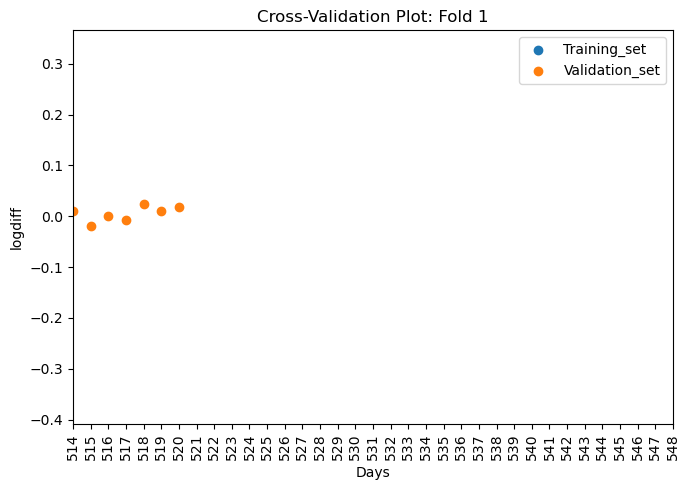

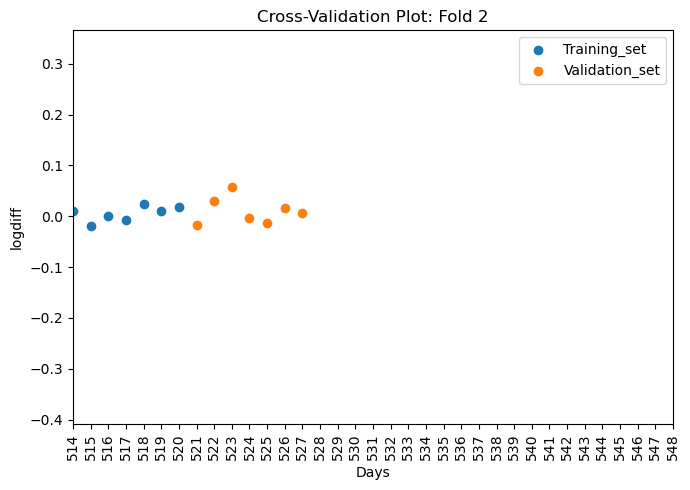

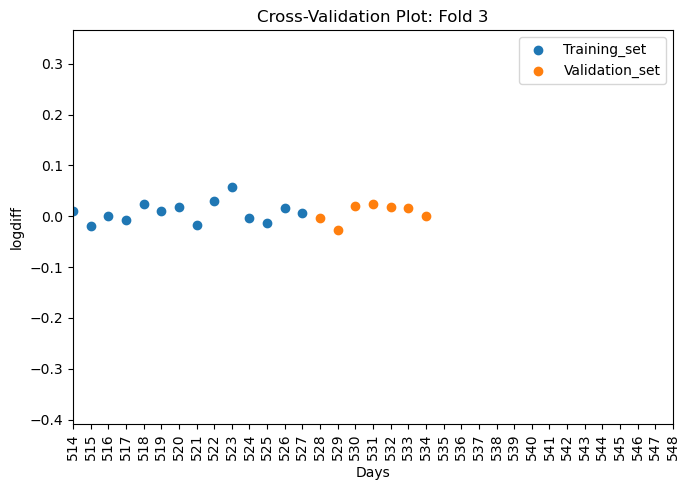

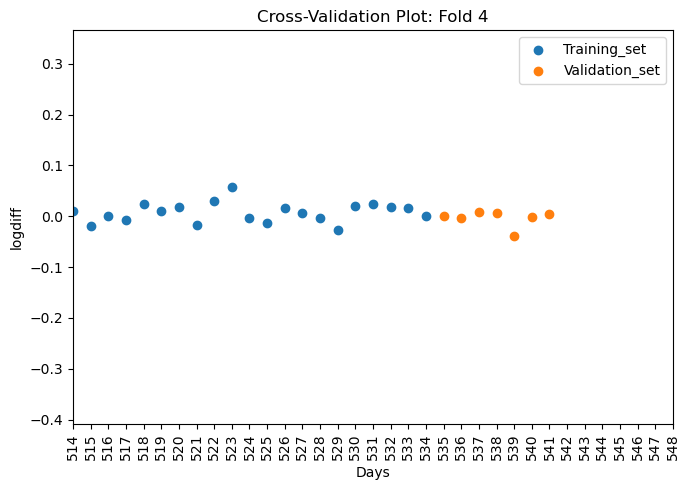

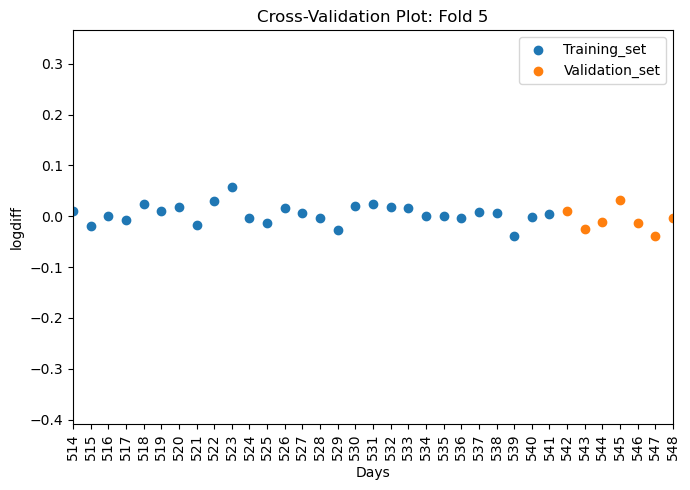

In [60]:
cross_validation_plot(clean_num_ind, 'logdiff', 7, 5)

Why bother? First, we would like to know how our model generalizes on the unseen data, as well as prediction error 'on average'. Second, machine learning models usually have lots of parameters that need to be tuned. Cross-validation is helpful in both cases.

In [61]:
def smape(y_true, y_pred):
        numerator = np.abs(y_true - y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred))
        ratio = numerator / denominator
        return ratio.mean()

In [62]:
def get_cv_preds(data, targetx, exogenousx, target_lags, exogenousx_upper, horizon, model, nfolds, debug = False, get_dataframe = False, get_info = False):
    
    
    #valid_indices = []
    
    length = len(data) - horizon*nfolds
    
    error = []
    out = exogenousx + targetx
    cnt = 0
    sign_cnt = 0

    for fold in range(1, nfolds + 1):
        preds = []
        train_data = data[:length].copy()
        valid_data = data[length:length+horizon][targetx].copy()
        
        for iter in range(1, horizon + 1):
            
            if iter == 1: 
                a, lags = gen_feats(train_data, target = targetx, exogenous = exogenousx, target_lags = target_lags, exogenous_lags_range= [horizon,exogenousx_upper])
            else:
                a, lags = gen_feats(a, target = targetx, exogenous = exogenousx, target_lags = target_lags, exogenous_lags_range= [horizon, exogenousx_upper])
            
            
            
            
            train_set, test_set = a[:-1].copy(), a[-1:].copy()

            xtrain = train_set[lags].dropna()
            train_id = xtrain.index
            ytrain = train_set[targetx].dropna().loc[train_id]
            
            #print(xtrain)
            #print(ytrain)
            model.fit(xtrain, ytrain.values.ravel())
            pred = model.predict(test_set[lags])
            pred = pred.flatten()[0]
           
            
            test_set.loc[test_set.index[0], targetx[0]] = pred
            
            a.loc[a.index[-1], targetx[0]] = pred
            
            
            preds.append(pred)
            
            

            if np.array(valid_data)[iter-1] * preds[iter - 1] > 0:
                sign_cnt += 1
            
            # DEBUG
            if debug == True:
                print('train data')
                print(train_data)
                print('valid data')
                print(valid_data)
                print('xtrain')
                print(xtrain)
                print('ytrain')
                print(ytrain)
                print('predict this')
                print(test_set[lags])
                print('prediction')
                print(preds)
                print('naive forecast')
                print(train_data[targetx][-1:])
                print('all features')
                print(a)
                
            a = a[out]
        
            
        
            
        print(f'SMAPE for fold {fold} is {smape(np.array(valid_data), preds)}')
        print('-----------------------------------------------------------------------')
        
        
        print(f'Naive forecast for fold {fold} is {smape(np.array(valid_data), np.array(train_data[targetx][-1:]*horizon))}')
        print('***********************************************************************')
        

        if smape(np.array(valid_data), np.array(train_data[targetx][-1:]*horizon)) < smape(np.array(valid_data), preds):
            cnt += 1

    
        error.append(smape(np.array(valid_data), preds))
        #append new data
        length += horizon
        
        
        del train_data, valid_data, train_set, test_set, xtrain, ytrain
        gc.collect()
        
    
    print(f'Naive forecast beats the model {cnt} time(s) out of {nfolds}')
    print('#############################################################')
    print(f'Signs detected correctly: {sign_cnt} out of {horizon*nfolds} ')
    print(f'Mean SMAPE of the model: {np.mean(error)}')
    
    if get_dataframe == True:
        return round(np.mean(error), 6), a
    elif get_info == True:  
        return [round(np.mean(error), 6), cnt/nfolds, sign_cnt/(horizon*nfolds)]
    else:
        return round(np.mean(error), 6)

This function does exactly that. I was planning to measure performance of the forecast with Symmetric Mean Absolute Percentage Error (SMAPE). This metric is bounded by 0 from below and by 100 from above thus, unlike MAPE, it does not explode to some huge numbers. However, there are a few nuances to know about SMAPE. First, it is undefined if both y_true and y_pred are zero. Second, it punishes underprediction more than overprediction. Let me illustrate what I mean by that:

In [63]:
def smape(y_true, y_pred):
        numerator = np.abs(y_true - y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred))
        ratio = numerator / denominator
        return ratio.mean()

Suppose that we need to predict X and **the true value of X is 1**. We run a model that gives us 1.1 as our prediction:

In [64]:
smape(1, 1.1)

0.04761904761904766

However, another model gives us the prediction of 0.9:

In [65]:
smape(1, 0.9)

0.05263157894736841

Then, our error is larger. Let's make a plot of SMAPE in relation to our predictions:

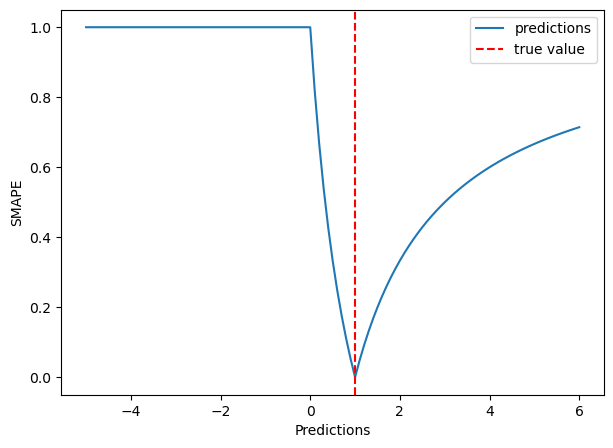

In [66]:
q = np.arange(-5,6.1, 0.1)
j = [smape(1, i) for i in q]
ax = plt.figure(figsize = (7,5))
plt.plot(q,j, label = 'predictions')
plt.xlabel('Predictions')
plt.ylabel('SMAPE')
plt.axvline(1, linestyle = '--', label = 'true value', color = 'red')
plt.legend()
plt.show()

The logical question that arises from this graph is 'Why is SMAPE called symmetric if its graph has nothing to do with symmetry?'. The answer is simple - SMAPE is called symmetric because we can change the places of y_true and y_pred and still get the same error:

In [67]:
smape(1, 0.5)

0.3333333333333333

In [68]:
smape(0.5, 1)

0.3333333333333333

Another thing to note about SMAPE is that this metric is relative:

In [69]:
smape(1, 0.5)

0.3333333333333333

In [70]:
smape(100, 50)

0.3333333333333333

In [71]:
smape(1000000000000, 500000000000)

0.3333333333333333

For our problem, is it good to minimize SMAPE? Given the information above, our model punishes more for underpredicting. On the other hand, underpredicting is actually a safer strategy - we would like to have our actual returns higher than predicted returns, just to be on the safe side. Thus, we might want to consider some alternative metrics.

The cross-validation function above also tells us how many times our model has beaten the naive forecast and how many times our model guessed the sign of the true value correctly. Many works and published papers usually ignore this aspect (they also tend to publish low forecast errors, but they compare the models with each other rather than comparing it to naive forecast), but it is very important: we want to have a model that beats the naive forecast, since naive forecast is the simplest form of forecast we can actually do. We would also like to guess the sign of the return for most of the predictions, since predicting a rise in returns with a  in returns as an actual event would result in loss of money if one is to believe the forecast. These two factors are already integrated into the function.

One possible function we could use as our loss is this custom loss function:

In [72]:
def custom_loss(y_true, y_pred):
        function = np.sqrt(5*np.exp(y_pred - y_true) - 5 - 5*(y_pred - y_true))
        return function.mean()

Let's plot it:

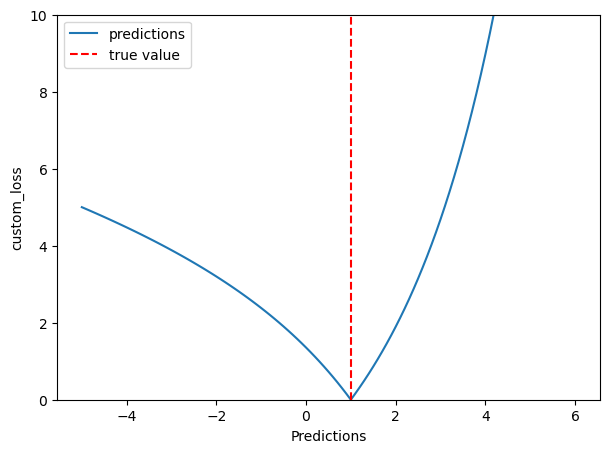

In [73]:
q = np.arange(-5,6.1, 0.1)
j = [custom_loss(1, i) for i in q]
ax = plt.figure(figsize = (7,5))
plt.plot(q,j, label = 'predictions')
plt.xlabel('Predictions')
plt.ylabel('custom_loss')
plt.ylim(0,10)
plt.axvline(1, linestyle = '--', label = 'true value', color = 'red')
plt.legend()
plt.show()

We can see that the slope of this function to the right of our target is less steep than the slope to the left of our target, which implies that we are punishing for overprediction more than for underprediction. This function is also well-behaved, making us able to take the first and the second derivatives.

In [109]:
def get_cv_preds_custom_loss(data, targetx, exogenousx, target_lags, exogenousx_upper, horizon, model, nfolds, debug = False, get_dataframe = False, get_info = False, explain = False):
    
    length = len(data) - horizon*nfolds
    
    error = []
    out = exogenousx + targetx
    cnt = 0
    sign_cnt = 0

    for fold in range(1, nfolds + 1):
        preds = []
        train_data = data[:length].copy()
        valid_data = data[length:length+horizon][targetx].copy()
        
        for iter in range(1, horizon + 1):
            
            if iter == 1: 
                a, lags = gen_feats(train_data, target = targetx, exogenous = exogenousx, target_lags = target_lags, exogenous_lags_range= [horizon,exogenousx_upper])
            else:
                a, lags = gen_feats(a, target = targetx, exogenous = exogenousx, target_lags = target_lags, exogenous_lags_range= [horizon, exogenousx_upper])
            
            train_set, test_set = a[:-1].copy(), a[-1:].copy()

            xtrain = train_set[lags].dropna()
            train_id = xtrain.index
            ytrain = train_set[targetx].dropna().loc[train_id]
            
            
            model.fit(xtrain, ytrain.values.ravel())
            pred = model.predict(test_set[lags])
            pred = pred.flatten()[0]
           
            
            test_set.loc[test_set.index[0], targetx[0]] = pred
            
            a.loc[a.index[-1], targetx[0]] = pred
            
            
            preds.append(pred)
            
            
            if np.sign(np.array(valid_data).flatten()[iter-1]) == np.sign(preds[iter - 1]):
                sign_cnt += 1
            
            # DEBUG
            if debug == True:
                print('train data')
                print(train_data)
                print('valid data')
                print(valid_data)
                print('xtrain')
                print(xtrain)
                print('ytrain')
                print(ytrain)
                print('predict this')
                print(test_set[lags])
                print('prediction')
                print(preds)
                print('naive forecast')
                print(train_data[targetx][-1:])
                print('all features')
                print(a)
                
            a = a[out]

        if explain == True:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(xtrain)
            shap.summary_plot(shap_values, xtrain)

        loss = custom_loss(np.array(valid_data).flatten(), preds)
        naive = custom_loss(np.array(valid_data).flatten(), np.full((1,horizon),np.array(train_data[targetx][-1:])))


            
        print(f'Custom loss for fold {fold} is {loss}')
        print('-----------------------------------------------------------------------')
        
        
        print(f'Naive forecast for fold {fold} is {naive}')
        print('***********************************************************************')
        

        if naive < loss:
            cnt += 1

    
        error.append(custom_loss(np.array(valid_data), preds))
        #append new data
        length += horizon
        
        
        del train_data, valid_data, train_set, test_set, xtrain, ytrain
        gc.collect()
        
    penalized_loss = np.mean(error) + np.mean(error)*cnt/nfolds - np.mean(error)*sign_cnt/(horizon*nfolds)
    
    print(f'Naive forecast beats the model {cnt} time(s) out of {nfolds}')
    print('#############################################################')
    print(f'Signs detected correctly: {sign_cnt} out of {horizon*nfolds} ')
    print(f'Mean loss of the model: {np.mean(error)}')
    print(f'Penalized loss of the model: {penalized_loss}')
    
    if get_dataframe == True:
        return round(penalized_loss, 6), a
    elif get_info == True:  
        return [round(penalized_loss, 6), round(cnt/nfolds* 100, 3), round(sign_cnt/(horizon*nfolds)* 100, 3)]
    else:
        return round(penalized_loss, 6)

The code above integrates this custom loss function into the cross-validation function. Notice that I also penalize the mean error of the model by the number of times the model lost to naive forecast and the number of incorrectly predicted signs. This is done because some models have lower mean error but they lose to the naive forecast more frequently or have a lot of incorrectly predicted signs, or both. It is also possible to put weights to either emphasize either cost, just like in the elastic net.

## Predicting one day ahead

Now that we have our setup ready, we can finally start some modelling. Since this is a regression problem, let's see how different popular regression algorithms will deal with it out of the box. Further section will mainly focus on the meta gradient boosting regressors, that were used to win major data science competitions.

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor

In [76]:
#define our models 
linreg = LinearRegression()
gradboost = GradientBoostingRegressor(random_state = 42)
sgdreg = SGDRegressor(random_state = 42)
svrreg = SVR()
rfreg = RandomForestRegressor(random_state = 42)
xgb = XGBRegressor(random_state = 42)
lgbm = LGBMRegressor(random_state = 42)

In [77]:
models = [linreg, gradboost, sgdreg, svrreg, rfreg, xgb, lgbm]
names = ['linear regression', 'gradient boosting', 'stochastic gradient descent', 'support vector regression', 'random forest regression', 'xgboost', 'lightgbm']
cnt = 0
d = {}
for model in models:
    print(model)
    d[names[cnt]] = get_cv_preds_custom_loss(clean_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = model, exogenousx_upper = 3, horizon = 1, nfolds= 30, get_info = True)
    cnt += 1

LinearRegression()
Custom loss for fold 1 is 0.026943811255997884
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.022417820103850086
***********************************************************************
Custom loss for fold 2 is 0.0074469022752031225
-----------------------------------------------------------------------
Naive forecast for fold 2 is 0.011616301517691345
***********************************************************************
Custom loss for fold 3 is 0.038186381902738195
-----------------------------------------------------------------------
Naive forecast for fold 3 is 0.054901449613959076
***********************************************************************
Custom loss for fold 4 is 0.03646369214164049
-----------------------------------------------------------------------
Naive forecast for fold 4 is 0.07266630440617958
***********************************************************************
Custom loss for fo

In [78]:
res = pd.DataFrame(np.column_stack(list(zip(*d.items()))), columns = ['model', 'Penalized_mean_loss', '%times_lost_to_naive_forecast', '%times_guessed_correct_sign'])
res.sort_values(['Penalized_mean_loss'], ascending=True)

,model,Penalized_mean_loss,%times_lost_to_naive_forecast,%times_guessed_correct_sign
2,stochastic gradient descent,0.022022,43.333,56.667
0,linear regression,0.023171,36.667,53.333
4,random forest regression,0.027921,43.333,46.667
6,lightgbm,0.030447,53.333,50.0
1,gradient boosting,0.032043,50.0,43.333
5,xgboost,0.037005,53.333,43.333
3,support vector regression,0.058721,60.0,33.333


From this table, we can see the that the SGD performs best on the 30 day walk-forward validation set. On average, it lost to the naive forecast about 40% of the time and about 60% of the time it got the prediction sign correctly. Linear regression, on the other hand, is better than naive forecast 37% of the time. Let's set it as our benchmark. Gradient boosting algorithms performed significantly worse. As we have used vanilla models only, it may be the case that we need to adjust the hyperparameters in order to increase the performance. One way to do this is to use optuna. We need to define an objective function that outputs some metric to be minimized. Optuna then will find the parameters that minimize this objective function. Beware, that it may take a long time to train (depends on the number of parameters and cpu/gpu). 

Here is the sample code for tuning LGBMRegressor. The code is grayed out intentionally.

In [79]:
#def objective(trial,  dataf = clean_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume','hl', 'co'], target_lags = 5, exogenousx_upper = 3, horizon = 1,
#    nfolds= 30):
#   
#   
#
#    
#    param = {
#        'objective': trial.suggest_categorical('objective', ['mae']),
#        #'tree_method':'hist',  # this parameter means using the GPU when training our model to speedup the training process
#        'reg_lambda': trial.suggest_int('lambda',1, 60),
#        'reg_alpha': trial.suggest_int('alpha', 1, 60),
#        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.1,0.3,0.5,0.7,0.9,1.0]),
#        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#        'learning_rate': trial.suggest_categorical('learning_rate', [0.001, 0.008,0.01,0.012,0.014,0.016,0.018, 0.02, 0.025]),
#        'n_estimators': trial.suggest_categorical('n_estimators', [15000]),
#        'max_depth': trial.suggest_categorical('max_depth', [7,9,11,13,15,17,20]),
#        "num_leaves": trial.suggest_int("num_leaves", 10, 1490, step=20),
#        'random_state': trial.suggest_categorical('random_state', [42]),
#        'min_child_weight': trial.suggest_categorical('min_child_weight', [1,5, 10, 20, 40, 80, 100]),   
#    }
#    
#    model = lgbm.LGBMRegressor(**param)
#    
#    return get_cv_preds_custom_loss(data = dataf, targetx = targetx, exogenousx = exogenousx, 
#                        target_lags = target_lags, exogenousx_upper = exogenousx_upper,
#                        horizon = horizon, nfolds = nfolds, model = model)  

#study = optuna.create_study(study_name = 'LGBMtuning')  
#study.optimize(objective, n_trials = 100)  
    

The tuning attempts were made to improve the score and the accuracy of both XGboost and LightGBM. The suggested hyperparameters were as follows:

In [80]:
#lightgbm
pars = {'objective': 'mae', 'lambda': 49, 'alpha': 32, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 15000, 'max_depth': 20, 'num_leaves': 1370, 'random_state': 42, 'min_child_weight': 80}
lgbm_t= LGBMRegressor(**pars)
d['lgbm_t'] = get_cv_preds_custom_loss(clean_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = lgbm_t, exogenousx_upper = 3, horizon = 1, nfolds= 30, get_info = True)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
Custom loss for fold 1 is 0.01704237733362998
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.022417820103850086
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
Custom loss for fold 2 is 0.016402023996507534
-----------------------------------------------------------------------
Naive forecast for fold 2 is 0.011616301517691345
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
Custom loss for fold 3 is 0.02758380193225931
-----------------------------------------------------------------------
Naive forecast for fold 3 is 0.0549014496

In [81]:
#xgboost
pars_xgb = {'objective': 'reg:pseudohubererror', 'lambda': 56, 'alpha': 2, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.03, 'n_estimators': 15000, 'max_depth': 13, 'random_state': 42, 'min_child_weight': 80}
xgb_t = XGBRegressor(**pars_xgb)
d['xgb_t'] = get_cv_preds_custom_loss(clean_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = xgb_t, exogenousx_upper = 3, horizon = 1, nfolds= 30, get_info = True)

Custom loss for fold 1 is 0.01286041046908856
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.022417820103850086
***********************************************************************
Custom loss for fold 2 is 0.01768612906147358
-----------------------------------------------------------------------
Naive forecast for fold 2 is 0.011616301517691345
***********************************************************************
Custom loss for fold 3 is 0.023844547161523434
-----------------------------------------------------------------------
Naive forecast for fold 3 is 0.054901449613959076
***********************************************************************
Custom loss for fold 4 is 0.03781721516526196
-----------------------------------------------------------------------
Naive forecast for fold 4 is 0.07266630440617958
***********************************************************************
Custom loss for fold 5 is 0.078647131167

We can notice that although both models have lower error than the simple linear regression. Moreover, they are definitely better than their baseline versions. However, notice that although they indeed have a lower error, none of them is better in terms of outperforming the naive forecast compared to linear regression. We can try to stack their predictions together, to see if they will perform better together:

In [82]:
from sklearn.ensemble import StackingRegressor
stack = [('tuned_lgbm', LGBMRegressor(**pars)),('tuned_xgb', XGBRegressor(**pars_xgb))]
stack_reg = StackingRegressor(estimators= stack, final_estimator = LinearRegression())

In [83]:
d['stacked_reg'] = get_cv_preds_custom_loss(clean_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = stack_reg, exogenousx_upper = 3, horizon = 1, nfolds= 30, get_info = True)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
Custom loss for fold 1 is 0.015060927064674837
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.022417820103850086
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
[LightGBM] [Warning] lambda_l2 is set w

In [84]:
res_n = pd.DataFrame(np.column_stack(list(zip(*d.items()))), columns = ['model', 'Penalized_mean_loss', '%times_lost_to_naive_forecast', '%times_guessed_correct_sign'])
res_n.sort_values(['Penalized_mean_loss'], ascending=True)

,model,Penalized_mean_loss,%times_lost_to_naive_forecast,%times_guessed_correct_sign
8,xgb_t,0.018656,40.0,63.333
7,lgbm_t,0.019373,43.333,60.0
9,stacked_reg,0.020941,33.333,50.0
2,stochastic gradient descent,0.022022,43.333,56.667
0,linear regression,0.023171,36.667,53.333
4,random forest regression,0.027921,43.333,46.667
6,lightgbm,0.030447,53.333,50.0
1,gradient boosting,0.032043,50.0,43.333
5,xgboost,0.037005,53.333,43.333
3,support vector regression,0.058721,60.0,33.333


Overall, the stacked regressor performs similarly to tuned LGBM. Using other meta-learners does not improve the loss.

Now we can try to see our model in action on the data for the next month:

In [85]:
df_full = yf.download("KSPI.IL")
df_full = df_full[df_full.index <= '2023-01-16']
df_full

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-15,38.000000,44.959999,33.750000,41.500000,38.185608,4952506
2020-10-16,42.200001,43.485001,41.110001,42.250000,38.875710,428297
2020-10-19,42.994999,42.994999,40.275002,41.500000,38.185608,92311
2020-10-20,40.105000,42.000000,40.105000,41.799999,38.461651,276481
2020-10-21,42.450001,42.549999,41.099998,41.750000,38.415646,129435
...,...,...,...,...,...,...
2023-01-10,71.699997,76.500000,71.699997,72.000000,72.000000,30976
2023-01-11,73.000000,74.000000,73.000000,74.000000,74.000000,18538
2023-01-12,74.000000,76.000000,74.000000,75.000000,75.000000,24826


In [86]:
clean_full = df_full.copy()
clean_full['logdiff'] = np.log(clean_full['Close']).diff()
datetime_id_full = clean_full.reset_index()['Date']
clean_full['h-l'] = clean_full['High'].copy() - clean_full['Low'].copy()
clean_full['c-o'] = clean_full['Close'].copy() - clean_full['Open'].copy()
clean_full.drop(['Close', 'High', 'Low', 'Open'], axis = 1, inplace = True)
clean_full_num_ind = clean_full.reset_index().drop(['Date', 'Adj Close'], axis = 1).copy()
clean_full_num_ind

,Volume,logdiff,h-l,c-o
0,4952506,NaN,11.209999,3.500000
1,428297,0.017911,2.375000,0.049999
2,92311,-0.017911,2.719997,-1.494999
3,276481,0.007203,1.895000,1.695000
4,129435,-0.001197,1.450001,-0.700001
...,...,...,...,...
562,30976,0.000000,4.800003,0.300003
563,18538,0.027399,1.000000,1.000000
564,24826,0.013423,2.000000,1.000000
565,36394,0.019803,3.099998,1.000000


In [87]:
models = [linreg, gradboost, sgdreg, svrreg, rfreg, xgb, lgbm]
names = ['linear regression', 'gradient boosting', 'stochastic gradient descent', 'support vector regression', 'random forest regression', 'xgboost', 'lightgbm']
cnt = 0
valid = {}
for model in models:
    print(model)
    valid[names[cnt]] = get_cv_preds_custom_loss(clean_full_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = model, exogenousx_upper = 3, horizon = 1, nfolds= 30, get_info = True)
    cnt += 1

LinearRegression()
Custom loss for fold 1 is 0.005561431553316821
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.016581741713438423
***********************************************************************
Custom loss for fold 2 is 0.011302655819729267
-----------------------------------------------------------------------
Naive forecast for fold 2 is 0.002149816518804111
***********************************************************************
Custom loss for fold 3 is 0.06013527751199437
-----------------------------------------------------------------------
Naive forecast for fold 3 is 0.07370377993893203
***********************************************************************
Custom loss for fold 4 is 0.001206047406409552
-----------------------------------------------------------------------
Naive forecast for fold 4 is 0.0603110226808726
***********************************************************************
Custom loss for fold 

In [88]:
valid['lgbm_t'] = get_cv_preds_custom_loss(clean_full_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = lgbm_t, exogenousx_upper = 3, horizon = 1, nfolds= 30, get_info = True)
valid['xgb_t'] = get_cv_preds_custom_loss(clean_full_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = xgb_t, exogenousx_upper = 3, horizon = 1, nfolds= 30, get_info = True)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
Custom loss for fold 1 is 0.011023101164292018
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.016581741713438423
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
Custom loss for fold 2 is 0.005297179287291925
-----------------------------------------------------------------------
Naive forecast for fold 2 is 0.002149816518804111
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49
Custom loss for fold 3 is 0.07417489822270057
-----------------------------------------------------------------------
Naive forecast for fold 3 is 0.073703779

In [89]:
res_all = pd.DataFrame(np.column_stack(list(zip(*valid.items()))), columns = ['model', 'Penalized_mean_loss', '%times_lost_to_naive_forecast', '%times_guessed_correct_sign'])
res_all.sort_values(['Penalized_mean_loss'], ascending=True)

,model,Penalized_mean_loss,%times_lost_to_naive_forecast,%times_guessed_correct_sign
0,linear regression,0.019584,26.667,53.333
2,stochastic gradient descent,0.019866,36.667,56.667
7,lgbm_t,0.022098,33.333,50.0
8,xgb_t,0.022348,33.333,46.667
4,random forest regression,0.02607,33.333,43.333
1,gradient boosting,0.030398,43.333,36.667
6,lightgbm,0.033761,46.667,43.333
5,xgboost,0.035463,43.333,40.0
3,support vector regression,0.076426,70.0,43.333


We can notice that the simple linear regression and SGD outperforms the tuned models on new data. It may be the case that tuning becomes irrelevant after just a couple of days and the model should be tuned more frequently.

It is also important to keep in mind that the stock price data is noisy and the models may not generalize well because of that. After all, predicting stock returns is not that simple.

In practice, organizations often prefer to have some understanding about the features of the model. Suppose that we have a model that predicts stock returns with 70% success rate. We would like to know the features that are selected by the model (i.e. what features have the most information on the stock returns) and maybe exploit them in different ways. If we use algorithms like neural networks or random forest, we wouldn't be able to retrieve the information on how the prediction was done, since they are 'black box' models. However, it is actually possible to do with non-black-box models - LGBM and XGB, for instance, have their native feature explainers. 

In our case, I use SHAP for feature explanation. It provides an interpretation of how each feature contributes to the prediction, and how the prediction would change if the features were different. It does not work with all models, but it works fine with XGB and LGBM. It is inplemented in the cross-validation function, you just need to add explain = True to get the graph for every last iteration of each fold:

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49


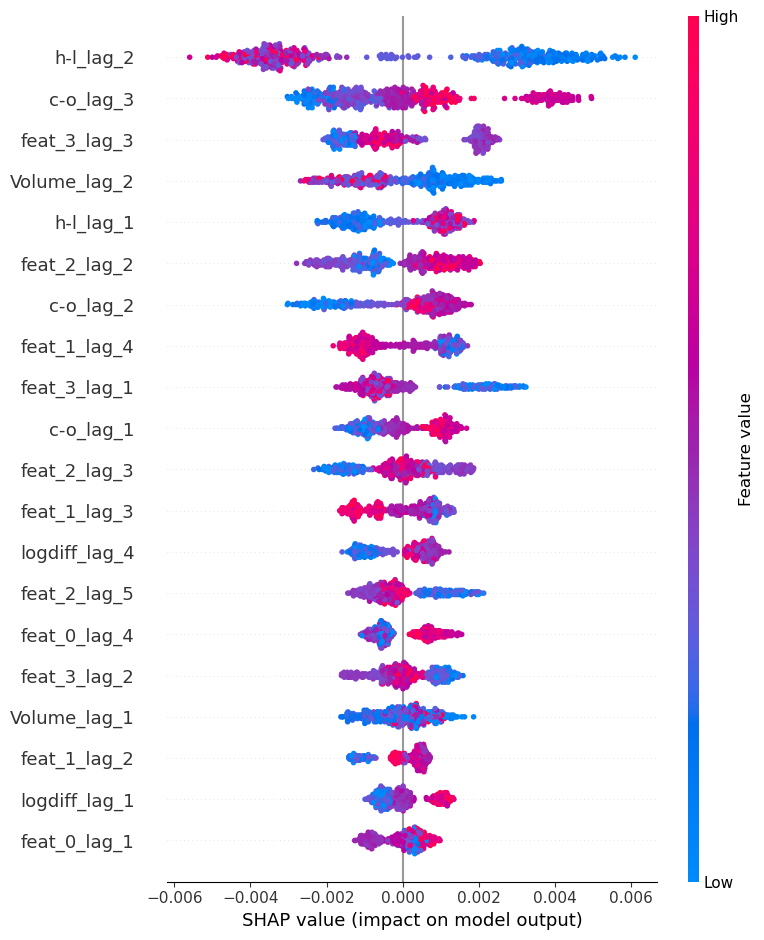

Custom loss for fold 1 is 0.03046087643900967
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.023146650384692033
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49


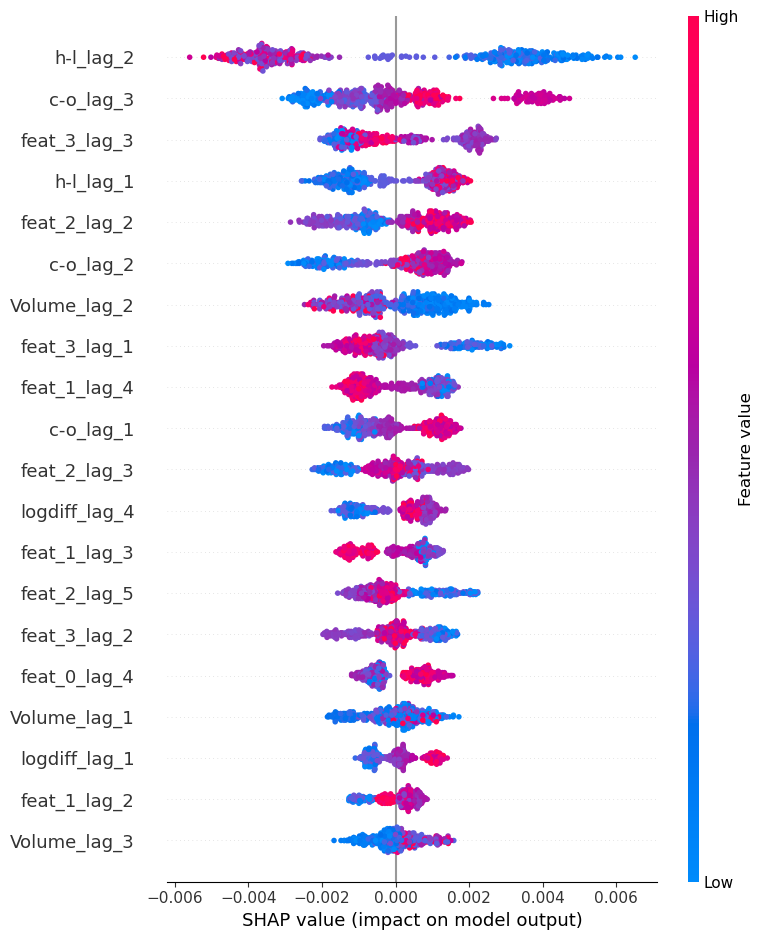

Custom loss for fold 2 is 0.05445703367401459
-----------------------------------------------------------------------
Naive forecast for fold 2 is 0.06653643724296833
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49


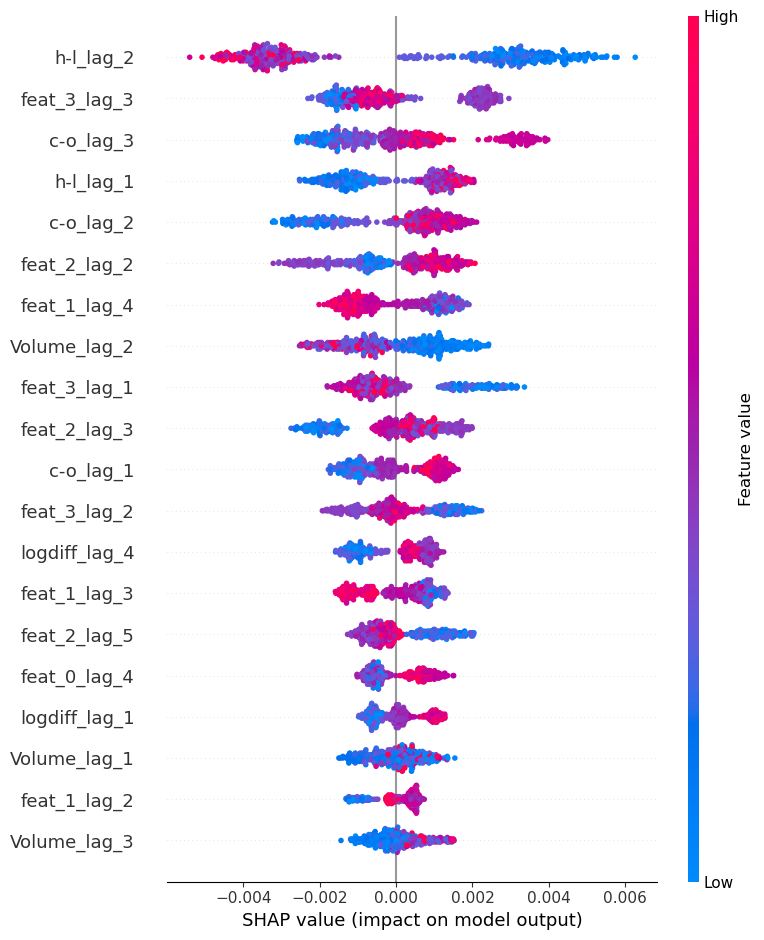

Custom loss for fold 3 is 0.014093132849299183
-----------------------------------------------------------------------
Naive forecast for fold 3 is 0.07148480625098919
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49


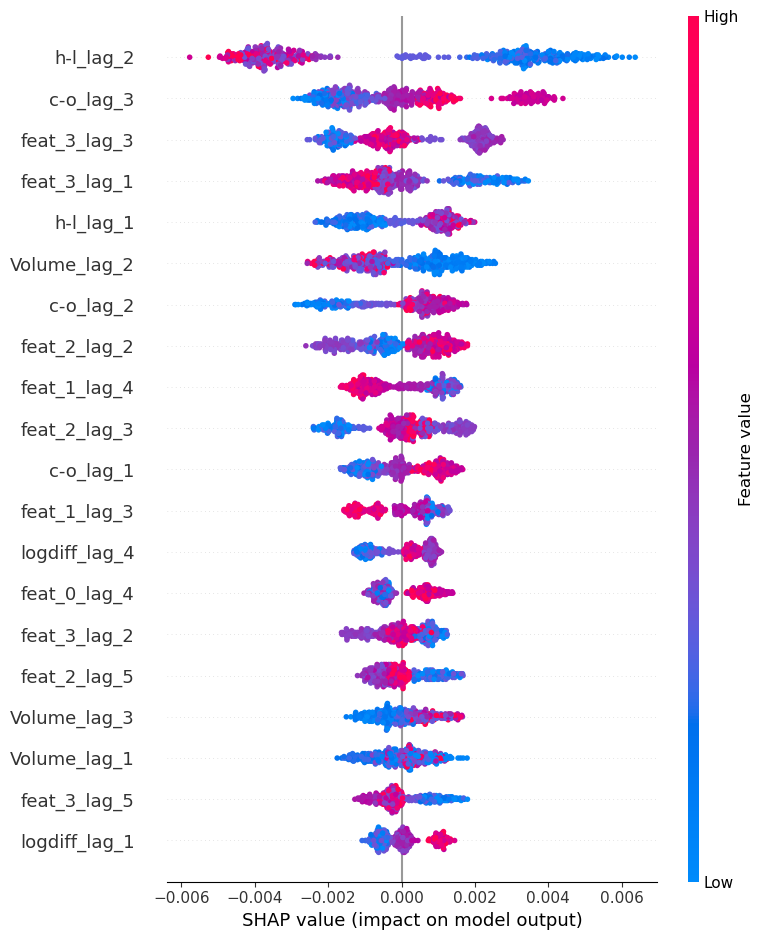

Custom loss for fold 4 is 0.05329349652664304
-----------------------------------------------------------------------
Naive forecast for fold 4 is 0.04021391412642973
***********************************************************************
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49


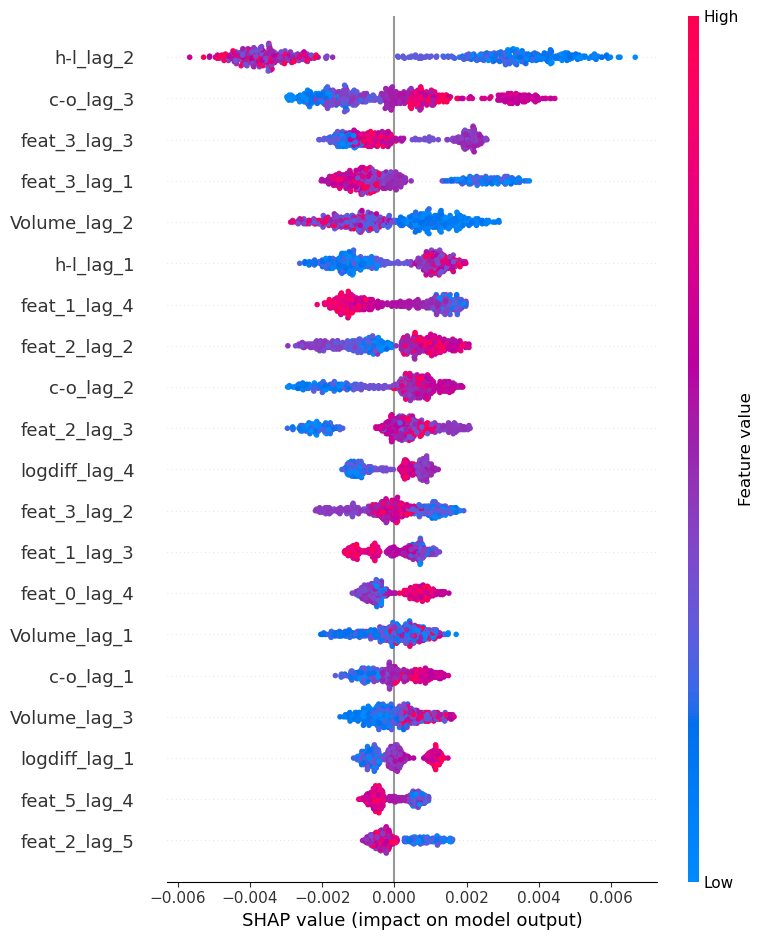

Custom loss for fold 5 is 0.01689981243039795
-----------------------------------------------------------------------
Naive forecast for fold 5 is 0.056592535951853984
***********************************************************************
Naive forecast beats the model 2 time(s) out of 5
#############################################################
Signs detected correctly: 2 out of 5 
Mean loss of the model: 0.03384087038387289
Penalized loss of the model: 0.03384087038387289


[0.033841, 40.0, 40.0]

In [111]:
get_cv_preds_custom_loss(clean_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = lgbm_t, exogenousx_upper = 3, horizon = 1, nfolds= 5, get_info = True, explain = True)

We can notice that the features have extremely small values which indicates that there are no strong predictors of the stock return in our model.

In [90]:
def get_forecast(data, targetx, exogenousx, target_lags,  exogenousx_upper, horizon, model):
    

    preds = []
    train_data = data.copy()
    
    out = exogenousx + targetx
   
    for iter in range(1, horizon + 1):
        print(f'Iteration number: {iter} out of {horizon}')
        print(f'-----------------------------------------')
        if iter == 1: 
            a, lags = gen_feats(train_data, target = targetx, exogenous = exogenousx, target_lags = target_lags, exogenous_lags_range= [horizon,exogenousx_upper])
        else:
            a, lags = gen_feats(a, target = targetx, exogenous = exogenousx, target_lags = target_lags, exogenous_lags_range= [horizon, exogenousx_upper])
        
        
        
        
        train_set, test_set = a[:-1].copy(), a[-1:].copy()

        xtrain = train_set[lags].dropna()
        train_id = xtrain.index
        ytrain = train_set[targetx].dropna().loc[train_id]

        model.fit(xtrain, ytrain)
        pred = model.predict(test_set[lags])
        
        
        test_set.loc[test_set.index[0], targetx[0]] = pred
        
        a.loc[a.index[-1], targetx[0]] = pred
        
        preds.append(pred[0])
        
        
        a = a[out]
        
       
        
        
    del train_data, train_set, test_set, xtrain, ytrain
    gc.collect()
        
    return a

The function above is a modified version of get_cv_preds function. It returns the forecast based on the specified horizon. Let's get the forecast for the next day by fitting our tuned LGBM model on the complete data:

In [91]:
forecast = get_forecast(clean_full_num_ind[1:], targetx=['logdiff'], target_lags = 5, exogenousx = ['Volume', 'h-l', 'c-o'], exogenousx_upper = 3, horizon = 1, model = lgbm_t)
forecast

Iteration number: 1 out of 1
-----------------------------------------
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=49. Current value: lambda_l2=49


,Volume,h-l,c-o,logdiff
1,6.778982,-0.458671,0.148973,0.017911
2,0.871800,-0.367497,-0.338390,-0.017911
3,4.109809,-0.585521,0.667880,0.007203
4,1.524501,-0.703123,-0.087612,-0.001197
5,-0.568030,-1.020250,0.180518,0.005970
...,...,...,...,...
563,-0.425250,-0.822045,0.448646,0.027399
564,-0.314696,-0.557773,0.448646,0.013423
565,-0.111312,-0.267074,0.448646,0.019803
566,-0.335003,-0.319927,-0.371512,-0.014483


## Predicting N days ahead

So far, we have seen that it is difficult to even make a one day ahead forecast. What if we actually wanted to predict N days ahead? This does not seem reasonable for daily stock returns; however, the motivation may be more clear if one wants to consider predicting smaller time frames (like hours or even minutes).

If that is the case, we just need to increase the horizon inside the cross-validation function. Let's do 3 day predictions with 30 fold cross-validation:
The stacked model is not included, since it takes some time to run; however, the stacked model offers no improvements over the tuned models for multiple step forecast.

In [96]:
models = [linreg, gradboost, sgdreg, svrreg, rfreg, xgb, lgbm, lgbm_t, xgb_t]
names = ['linear regression', 'gradient boosting', 'stochastic gradient descent', 'support vector regression', 'random forest regression', 'xgboost', 'lightgbm', 'tuned LGBM', 'tuned XGB']
cnt = 0
mult_pred = {}
for model in models:
    print(model)
    mult_pred[names[cnt]] = get_cv_preds_custom_loss(clean_num_ind[1:], targetx=['logdiff'], exogenousx=['Volume', 'h-l', 'c-o'], target_lags = 5, model = model, exogenousx_upper = 3, horizon = 3, nfolds= 30, get_info = True)
    cnt += 1

LinearRegression()
Custom loss for fold 1 is 0.037106292384137866
-----------------------------------------------------------------------
Naive forecast for fold 1 is 0.02557913565843672
***********************************************************************
Custom loss for fold 2 is 0.02630510498949713
-----------------------------------------------------------------------
Naive forecast for fold 2 is 0.038698955403897554
***********************************************************************
Custom loss for fold 3 is 0.04666756068119802
-----------------------------------------------------------------------
Naive forecast for fold 3 is 0.04889974706734718
***********************************************************************
Custom loss for fold 4 is 0.01990197985050904
-----------------------------------------------------------------------
Naive forecast for fold 4 is 0.08924644873866448
***********************************************************************
Custom loss for fold 5 

In [112]:
res_mult = pd.DataFrame(np.column_stack(list(zip(*mult_pred.items()))), columns = ['model', 'Penalized_mean_loss', '%times_lost_to_naive_forecast', '%times_guessed_correct_sign'])
res_mult.sort_values(['Penalized_mean_loss'], ascending=True)

,model,Penalized_mean_loss,%times_lost_to_naive_forecast,%times_guessed_correct_sign
8,tuned XGB,0.022354,20.0,48.889
5,xgboost,0.025494,23.333,50.0
1,gradient boosting,0.026732,30.0,47.778
0,linear regression,0.026951,26.667,45.556
2,stochastic gradient descent,0.028004,30.0,45.556
7,tuned LGBM,0.02861,36.667,50.0
4,random forest regression,0.032364,43.333,48.889
6,lightgbm,0.032421,40.0,48.889
3,support vector regression,0.058578,56.667,47.778


It seems like more of the multi-step models are better than naive forecast when compared to one-step forecast. This behavior is expected, since the naive forecast in this case is just the last known value duplicated three times. When we predicted one day ahead, the last known value was always changing. In general, all models guess the correct sign only ~50% of the time and it seems like tuned XGBoost performs better than others (this behavior might be inconsistent).

One might as well ask themselves a question - 'We are predicting stock returns, but what if I actually want to see prices from the predicted returns?'. It is actually not hard to convert them back to prices. Let's look at the multistep example:

In the first step we are predicting $\Delta{\hat{y}_{t+1}}$ which is equal to ${\hat{y}_{t+1}} - {{y}_{t}}$. Then, ${\hat{y}_{t+1}} = {y}_{t} + \Delta{\hat{y}_{t+1}}$.

For $\Delta{\hat{y}_{t+2}} = \hat{y}_{t+2} -  \hat{y}_{t+1}$.

Then, $\hat{y}_{t+2} = \hat{y}_{t+1} + \Delta{\hat{y}_{t+2}}$ which is equivalent to $\hat{y}_{t+2} = {y}_{t} + \Delta{\hat{y}_{t+1}} + \Delta{\hat{y}_{t+2}}$.

$\hat{y}_{t+3} = {y}_{t} + \Delta{\hat{y}_{t+1}} + \Delta{\hat{y}_{t+2}} + \Delta{\hat{y}_{t+3}}$ 

... and so on.

This shows that to convert the log differences in prices back to prices for period t+n is equivalent of taking the last known value and adding cumulative sum of deltas from t to t+n. I will leave this as an exercise to reader, if somebody will actually read this. 

# Conclusion

What can we conclude from this project? First, it is best to have a simple baseline when forecasting something. That way we can actually know that our model is better than just replicating the last value. Second, machine learning has limited effectiveness in predicting stock returns. It looks that ML can predict the stock **prices** deceptively well, (most of the times, however, naive forecast has lower error when predicting stock prices - this aspect is not included even in journal publications) but once we take the difference in log prices to remove autocorrelation (in other words, try to predict the **log returns**), ML really struggles. The past data is not always a good predictor for future data, as was seen in this project. One might argue that maybe we can get better results with different stocks - indeed, there might be stocks that are 'easier' to predict with ML. However, the consistensy of these predictions is another issue to be adressed.